<a href="https://colab.research.google.com/github/msanchezj/ml-for-corporate-credit-rating/blob/main/Corporate_Credit_Ratings_v0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install imbalanced-learn

In [ ]:
import pandas as pd
import numpy as np
from imblearn.over_sampling import SMOTENC
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
pd.set_option('display.max_columns', None)
rng = np.random.RandomState(16)

In [ ]:
from google.colab import drive
import os
drive.mount('/content/drive')
data_dir = os.path.join('content', 'drive', 'My Drive', 'TFM Credit', 'Data')
file = os.path.join(data_dir, "corporate_rating.csv")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, RobustScaler
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LinearRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_classif, f_classif
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, classification_report

class CreditRatingExperiment:

  def __init__(self, file):
    rating_map = {'AAA': 0, 'AA': 1, 'A': 2, 'BBB': 3, 'BB': 4, 'B': 5, 'CCC': 6, 'CC': 7, 'C': 8, 'D': 9}
    self.__data__ = pd.read_csv("file:///" + file)\
                .drop(['Symbol', 'Rating Agency Name', 'Date', 'Name', 'Sector'], axis=1)\
                .replace({'Rating': rating_map})
    self.__data__ = self.__data__[(self.__data__.Rating != 9) & (self.__data__.Rating != 8)]
    self.__rng__ = np.random.RandomState(14)

  def get_data(self):
    return self.__data__

  def get_rng(self):
    return self.__rng__

  def get_splitted_data(self, test_size):
    return train_test_split(self.get_data(), test_size=test_size, random_state=self.get_rng(), stratify=self.get_data().Rating)

  def get_train_test_data(self, test_size):
    train, test = self.get_splitted_data(test_size)
    x_train = train.loc[:, train.columns != 'Rating']
    y_train = train.Rating
    x_test = test.loc[:, test.columns != 'Rating']
    y_test = test.Rating

    return x_train, y_train, x_test, y_test

  def oversample(self, x_train, y_train):
    sm = SMOTE(random_state=14, k_neighbors=3)
    x_train_os, y_train_os = sm.fit_resample(x_train, y_train)

    return x_train_os, y_train_os

  def scale_data(self, x_train, x_test):
    scaler = RobustScaler(quantile_range=(0.05, 0.95))
    x_train = scaler.fit_transform(x_train)
    x_test = scaler.transform(x_test)

    return x_train, x_test

  def select_features(self, x_train, x_test, method):
    if method == 'mutual_information':
      fs = SelectKBest(score_func=mutual_info_classif, k=int(x_train.shape[1]/3))
    if method == 'ANOVA':
      fs = SelectKBest(score_func=f_classif, k=int(x_train.shape[1]/3))
    # learn relationship from training data
    fs.fit(x_train, y_train)
    # transform train input data
    X_train_fs = fs.transform(x_train)
    # transform test input data
    X_test_fs = fs.transform(x_test)
    print(fs.get_feature_names_out())

    return X_train_fs, X_test_fs

  def run(self, use_smote=True, use_scaling=True, feature_selection_method=None, test_size=0.2):
    train, test = self.get_splitted_data(test_size)
    x_train, y_train, x_test, y_test = self.get_train_test_data(test_size)

    if feature_selection_method is not None:
      x_train, x_test = self.select_features(x_train, x_test, feature_selection_method)

    if use_smote:
      x_train, y_train = self.oversample(x_train, y_train)

    if use_scaling:
      x_train, x_test = self.scale_data(x_train, x_test)

    self.run_baseline_model(train, test)
    self.run_lda(x_train, y_train, x_test, y_test)
    self.run_logistic_regression(x_train, y_train, x_test, y_test)
    self.run_svm(x_train, y_train, x_test, y_test)
    self.run_random_forest(x_train, y_train, x_test, y_test)
    self.run_neural_network(x_train, y_train, x_test, y_test)

  def run_baseline_model(self, train, test):
    x_train_bl = train.groupby('Rating').median()['debtRatio'].to_numpy().reshape(-1, 1)
    y_train_bl = train.groupby('Rating').median()['debtRatio'].index.to_numpy().reshape(-1, 1)
    x_test_bl = test['debtRatio'].to_numpy().reshape(-1, 1)
    y_test_bl = test.Rating.to_numpy().reshape(-1, 1)
    lr = LinearRegression()
    lr.fit(x_train_bl, y_train_bl)

    y_hat = lr.predict(x_test_bl)

    def predict_from_baseline(model, x_test):
      def piecewise_predictor(x):
        return np.piecewise(x, [x < 0.5,
                              ((x >= 0.5) & (x < 1.5)),
                              ((x >= 1.5) & (x < 32.5)),
                              ((x >= 2.5) & (x < 3.5)),
                              ((x >= 3.5) & (x < 4.5)),
                              ((x >= 4.5) & (x < 5.5)),
                              ((x >= 5.5) & (x < 6.5)),
                              x >= 6.5],
                              [0, 1, 2, 3, 4, 5, 6, 7])
      piecewise = np.vectorize(piecewise_predictor)
      pred = piecewise(model.predict(x_test))

      return pred

    y_hat = predict_from_baseline(lr, x_test_bl)
    c_matrix = confusion_matrix(y_test_bl, y_hat)

    ConfusionMatrixDisplay.from_predictions(y_test_bl, y_hat, cmap='Blues')
    plt.title('Matriz de Confusión para el modelo baseline')
    plt.show()
    print('Reporte de Clasificación para el modelo baseline:\n' + classification_report(y_test_bl, y_hat, zero_division=0))

  def run_lda(self, x_train, y_train, x_test, y_test):
    lda = LDA(solver='lsqr')
    lda.fit(x_train, y_train)

    y_hat = lda.predict(x_test)
    c_matrix = confusion_matrix(y_test, y_hat)

    ConfusionMatrixDisplay.from_predictions(y_test, y_hat, cmap='Blues')
    plt.title('Matriz de Confusión para el modelo Linear Discriminant Analysis')
    plt.show()
    print('Reporte de Clasificación para el modelo Linear Discriminant Analysis:\n' + classification_report(y_test, y_hat, zero_division=0))

  def run_logistic_regression(self, x_train, y_train, x_test, y_test):
    log_reg = LogisticRegression(penalty='none', solver='saga', class_weight='balanced', max_iter=10000, random_state=self.get_rng())
    log_reg.fit(x_train, y_train)

    y_hat = log_reg.predict(x_test)
    c_matrix = confusion_matrix(y_test, y_hat)

    ConfusionMatrixDisplay.from_predictions(y_test, y_hat, cmap='Blues')
    plt.title('Matriz de Confusión para el modelo Regresión Logística')
    plt.show()
    print('Reporte de Clasificación para el modelo Regresión Logística:\n' + classification_report(y_test, y_hat, zero_division=0))

  def run_svm(self, x_train, y_train, x_test, y_test):
    svc_rbf = SVC(kernel='rbf', C=1)

    svc_rbf.fit(x_train, y_train)

    y_hat = svc_rbf.predict(x_test)
    c_matrix = confusion_matrix(y_test, y_hat)

    ConfusionMatrixDisplay.from_predictions(y_test, y_hat, cmap='Blues')
    plt.title('Matriz de Confusión para el modelo de Maquinas de Vectores Soporte')
    plt.show()
    print('Reporte de Clasificación para el modelo de Maquinas de Vectores Soporte:\n' + classification_report(y_test, y_hat, zero_division=0))

  def run_random_forest(self, x_train, y_train, x_test, y_test):
    rfc = RandomForestClassifier(criterion='entropy', n_estimators=300, max_depth=10, bootstrap=True, random_state=rng)

    rfc.fit(x_train, y_train)

    y_hat = rfc.predict(x_test)
    c_matrix = confusion_matrix(y_test, y_hat)

    ConfusionMatrixDisplay.from_predictions(y_test, y_hat, cmap='Blues')
    plt.title('Matriz de Confusión para el modelo de Árboles Aleatorios')
    plt.show()
    print('Reporte de Clasificación para el modelo de Árboles Aleatorios:\n' + classification_report(y_test, y_hat, zero_division=0))

  def run_neural_network(self, x_train, y_train, x_test, y_test, loss_func='categorical_crossentropy'):
    model = Sequential()
    model.add(Dense(9, activation='relu', input_dim=x_train.shape[1]))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(9, activation='softmax'))

    y_train_enc = to_categorical(y_train, num_classes=9)

    model.compile(loss=loss_func, optimizer='adam', metrics=['accuracy'])
    model.fit(x_train, y_train_enc, epochs=850, batch_size=32, verbose=0)

    y_hat = list(map(np.argmax, model.predict(x_test)))

    ConfusionMatrixDisplay.from_predictions(y_test, y_hat, cmap='Blues')
    plt.title('Matriz de Confusión para el modelo de Red Neuronal')
    plt.show()
    print('Reporte de Clasificación para el modelo de Red Neuronal:\n' + classification_report(y_test, y_hat, zero_division=0))

## Con Scaler y Smote

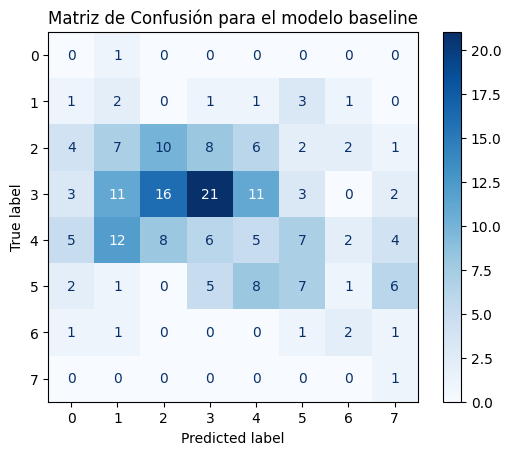

Reporte de Clasificación para el modelo baseline:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.06      0.22      0.09         9
           2       0.29      0.25      0.27        40
           3       0.51      0.31      0.39        67
           4       0.16      0.10      0.13        49
           5       0.30      0.23      0.26        30
           6       0.25      0.33      0.29         6
           7       0.07      1.00      0.12         1

    accuracy                           0.24       203
   macro avg       0.21      0.31      0.19       203
weighted avg       0.32      0.24      0.26       203



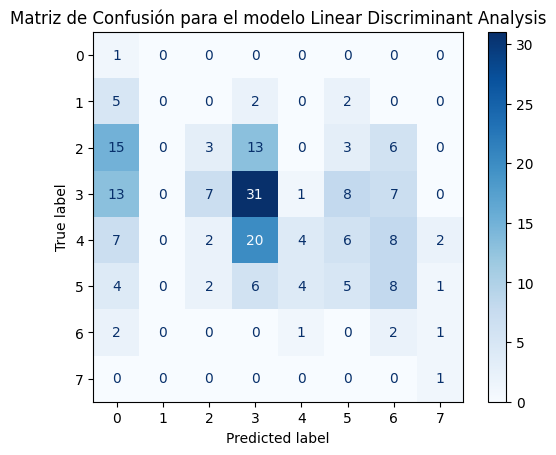

Reporte de Clasificación para el modelo Linear Discriminant Analysis:
              precision    recall  f1-score   support

           0       0.02      1.00      0.04         1
           1       0.00      0.00      0.00         9
           2       0.21      0.07      0.11        40
           3       0.43      0.46      0.45        67
           4       0.40      0.08      0.14        49
           5       0.21      0.17      0.19        30
           6       0.06      0.33      0.11         6
           7       0.20      1.00      0.33         1

    accuracy                           0.23       203
   macro avg       0.19      0.39      0.17       203
weighted avg       0.31      0.23      0.23       203



/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


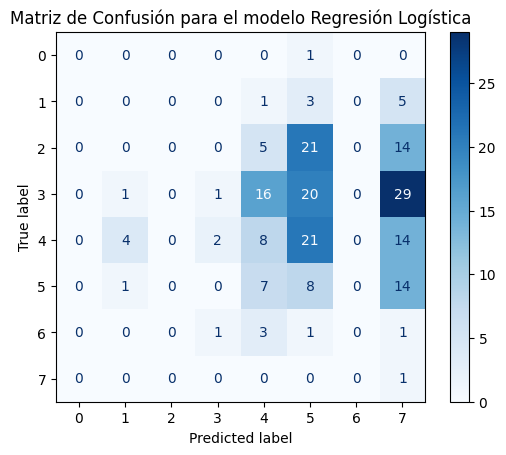

Reporte de Clasificación para el modelo Regresión Logística:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.00      0.00      0.00         9
           2       0.00      0.00      0.00        40
           3       0.25      0.01      0.03        67
           4       0.20      0.16      0.18        49
           5       0.11      0.27      0.15        30
           6       0.00      0.00      0.00         6
           7       0.01      1.00      0.03         1

    accuracy                           0.09       203
   macro avg       0.07      0.18      0.05       203
weighted avg       0.15      0.09      0.08       203



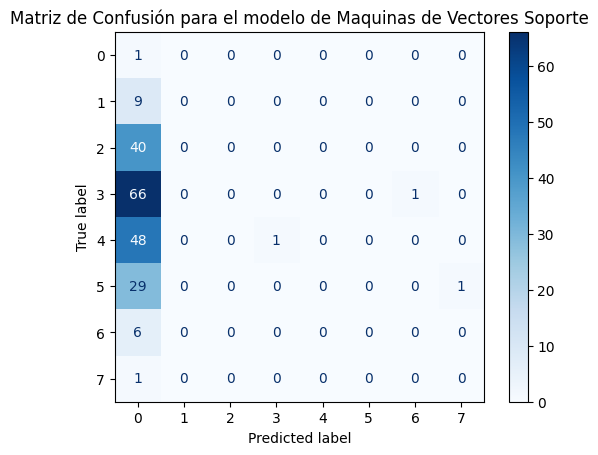

Reporte de Clasificación para el modelo de Maquinas de Vectores Soporte:
              precision    recall  f1-score   support

           0       0.01      1.00      0.01         1
           1       0.00      0.00      0.00         9
           2       0.00      0.00      0.00        40
           3       0.00      0.00      0.00        67
           4       0.00      0.00      0.00        49
           5       0.00      0.00      0.00        30
           6       0.00      0.00      0.00         6
           7       0.00      0.00      0.00         1

    accuracy                           0.00       203
   macro avg       0.00      0.12      0.00       203
weighted avg       0.00      0.00      0.00       203



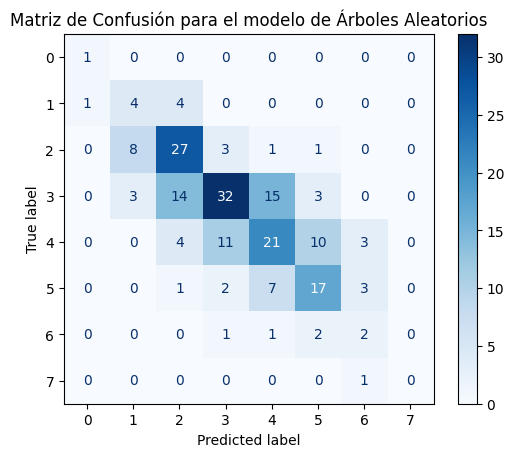

Reporte de Clasificación para el modelo de Árboles Aleatorios:
              precision    recall  f1-score   support

           0       0.50      1.00      0.67         1
           1       0.27      0.44      0.33         9
           2       0.54      0.68      0.60        40
           3       0.65      0.48      0.55        67
           4       0.47      0.43      0.45        49
           5       0.52      0.57      0.54        30
           6       0.22      0.33      0.27         6
           7       0.00      0.00      0.00         1

    accuracy                           0.51       203
   macro avg       0.40      0.49      0.43       203
weighted avg       0.53      0.51      0.51       203

7/7 [==============================] - 0s 3ms/step


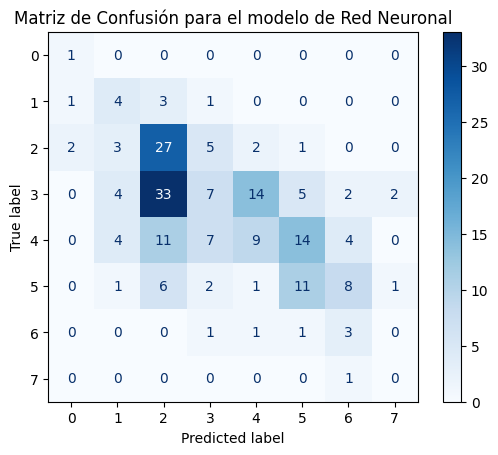

Reporte de Clasificación para el modelo de Red Neuronal:
              precision    recall  f1-score   support

           0       0.25      1.00      0.40         1
           1       0.25      0.44      0.32         9
           2       0.34      0.68      0.45        40
           3       0.30      0.10      0.16        67
           4       0.33      0.18      0.24        49
           5       0.34      0.37      0.35        30
           6       0.17      0.50      0.25         6
           7       0.00      0.00      0.00         1

    accuracy                           0.31       203
   macro avg       0.25      0.41      0.27       203
weighted avg       0.32      0.31      0.27       203



In [ ]:
experiment = CreditRatingExperiment(file)
experiment.run()

## Con Scaler

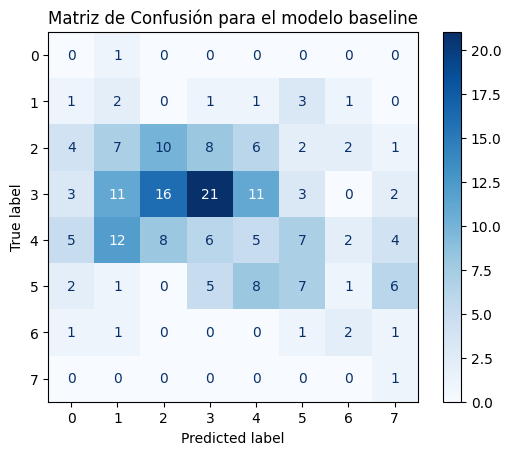

Reporte de Clasificación para el modelo baseline:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.06      0.22      0.09         9
           2       0.29      0.25      0.27        40
           3       0.51      0.31      0.39        67
           4       0.16      0.10      0.13        49
           5       0.30      0.23      0.26        30
           6       0.25      0.33      0.29         6
           7       0.07      1.00      0.12         1

    accuracy                           0.24       203
   macro avg       0.21      0.31      0.19       203
weighted avg       0.32      0.24      0.26       203



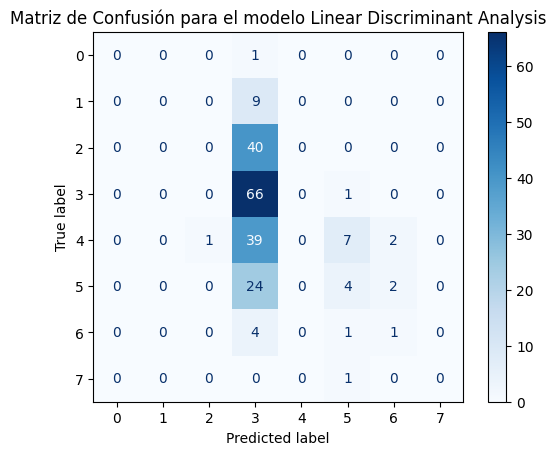

Reporte de Clasificación para el modelo Linear Discriminant Analysis:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.00      0.00      0.00         9
           2       0.00      0.00      0.00        40
           3       0.36      0.99      0.53        67
           4       0.00      0.00      0.00        49
           5       0.29      0.13      0.18        30
           6       0.20      0.17      0.18         6
           7       0.00      0.00      0.00         1

    accuracy                           0.35       203
   macro avg       0.11      0.16      0.11       203
weighted avg       0.17      0.35      0.21       203



/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


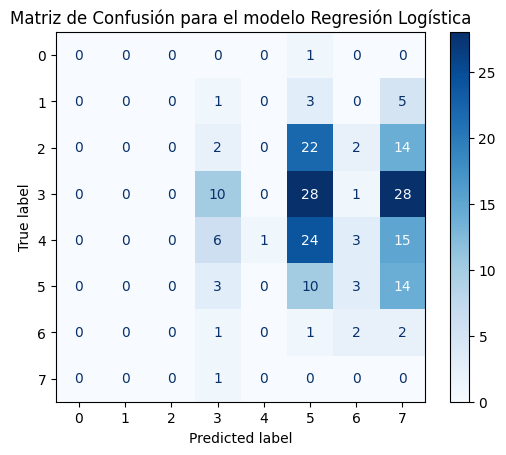

Reporte de Clasificación para el modelo Regresión Logística:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.00      0.00      0.00         9
           2       0.00      0.00      0.00        40
           3       0.42      0.15      0.22        67
           4       1.00      0.02      0.04        49
           5       0.11      0.33      0.17        30
           6       0.18      0.33      0.24         6
           7       0.00      0.00      0.00         1

    accuracy                           0.11       203
   macro avg       0.21      0.10      0.08       203
weighted avg       0.40      0.11      0.11       203



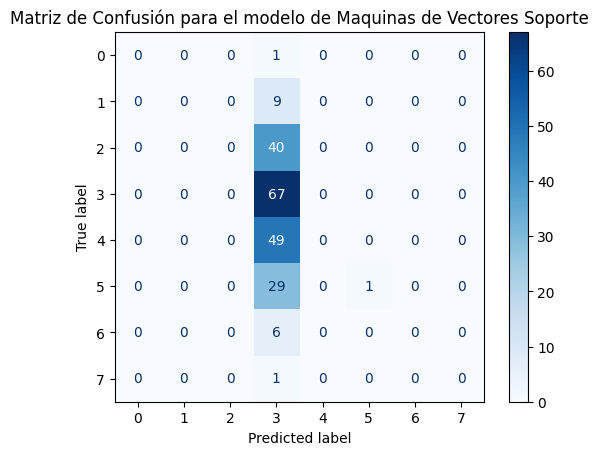

Reporte de Clasificación para el modelo de Maquinas de Vectores Soporte:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.00      0.00      0.00         9
           2       0.00      0.00      0.00        40
           3       0.33      1.00      0.50        67
           4       0.00      0.00      0.00        49
           5       1.00      0.03      0.06        30
           6       0.00      0.00      0.00         6
           7       0.00      0.00      0.00         1

    accuracy                           0.33       203
   macro avg       0.17      0.13      0.07       203
weighted avg       0.26      0.33      0.17       203



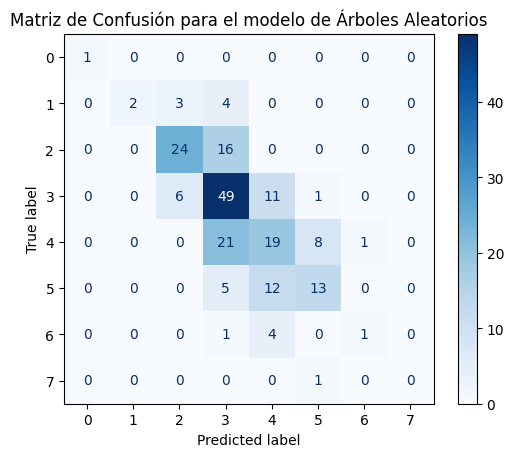

Reporte de Clasificación para el modelo de Árboles Aleatorios:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       1.00      0.22      0.36         9
           2       0.73      0.60      0.66        40
           3       0.51      0.73      0.60        67
           4       0.41      0.39      0.40        49
           5       0.57      0.43      0.49        30
           6       0.50      0.17      0.25         6
           7       0.00      0.00      0.00         1

    accuracy                           0.54       203
   macro avg       0.59      0.44      0.47       203
weighted avg       0.56      0.54      0.53       203

7/7 [==============================] - 0s 2ms/step


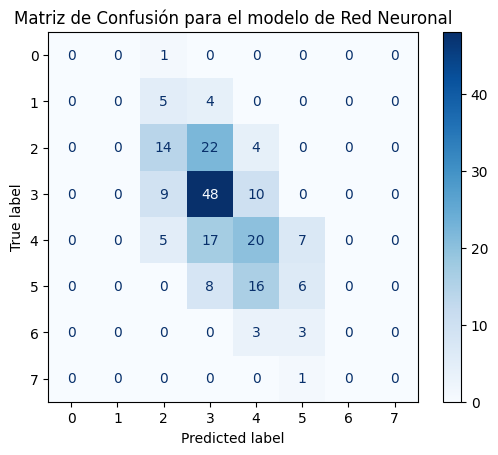

Reporte de Clasificación para el modelo de Red Neuronal:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.00      0.00      0.00         9
           2       0.41      0.35      0.38        40
           3       0.48      0.72      0.58        67
           4       0.38      0.41      0.39        49
           5       0.35      0.20      0.26        30
           6       0.00      0.00      0.00         6
           7       0.00      0.00      0.00         1

    accuracy                           0.43       203
   macro avg       0.20      0.21      0.20       203
weighted avg       0.38      0.43      0.40       203



In [ ]:
experiment = CreditRatingExperiment(file)
experiment.run()

## Sin preprocesamiento

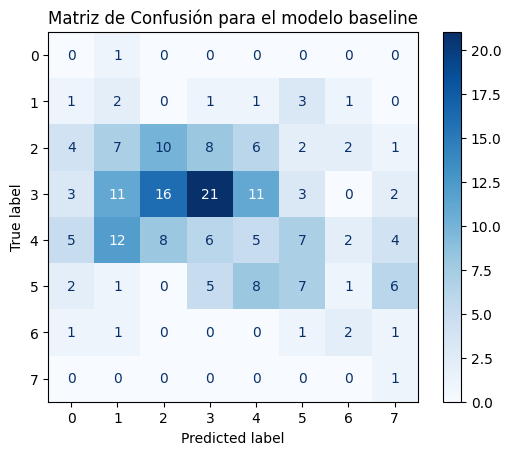

Reporte de Clasificación para el modelo baseline:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.06      0.22      0.09         9
           2       0.29      0.25      0.27        40
           3       0.51      0.31      0.39        67
           4       0.16      0.10      0.13        49
           5       0.30      0.23      0.26        30
           6       0.25      0.33      0.29         6
           7       0.07      1.00      0.12         1

    accuracy                           0.24       203
   macro avg       0.21      0.31      0.19       203
weighted avg       0.32      0.24      0.26       203



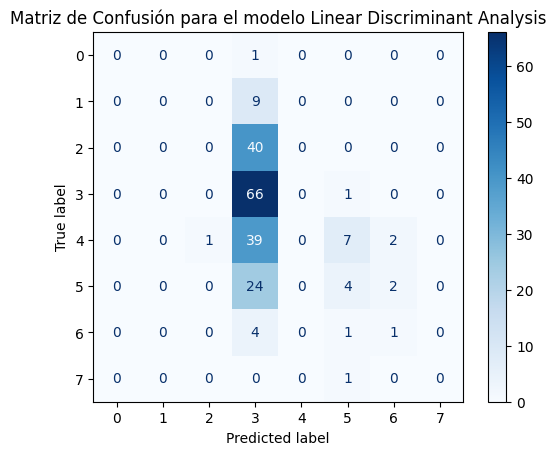

Reporte de Clasificación para el modelo Linear Discriminant Analysis:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.00      0.00      0.00         9
           2       0.00      0.00      0.00        40
           3       0.36      0.99      0.53        67
           4       0.00      0.00      0.00        49
           5       0.29      0.13      0.18        30
           6       0.20      0.17      0.18         6
           7       0.00      0.00      0.00         1

    accuracy                           0.35       203
   macro avg       0.11      0.16      0.11       203
weighted avg       0.17      0.35      0.21       203



/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


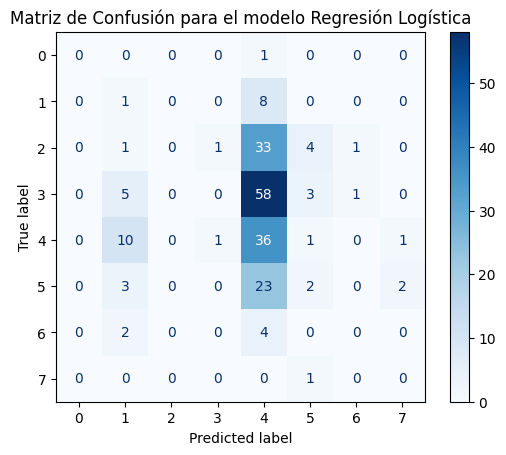

Reporte de Clasificación para el modelo Regresión Logística:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.05      0.11      0.06         9
           2       0.00      0.00      0.00        40
           3       0.00      0.00      0.00        67
           4       0.22      0.73      0.34        49
           5       0.18      0.07      0.10        30
           6       0.00      0.00      0.00         6
           7       0.00      0.00      0.00         1

    accuracy                           0.19       203
   macro avg       0.06      0.11      0.06       203
weighted avg       0.08      0.19      0.10       203



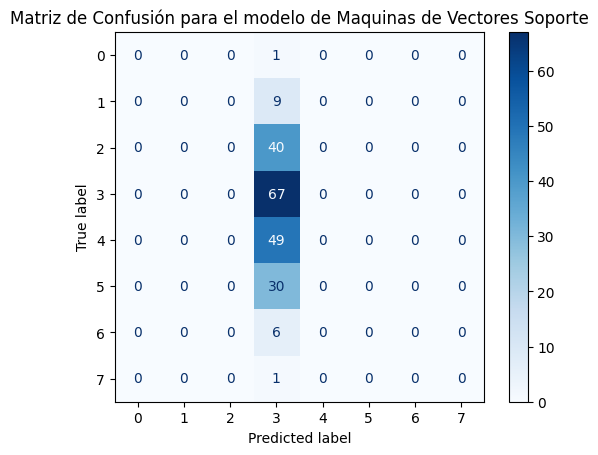

Reporte de Clasificación para el modelo de Maquinas de Vectores Soporte:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.00      0.00      0.00         9
           2       0.00      0.00      0.00        40
           3       0.33      1.00      0.50        67
           4       0.00      0.00      0.00        49
           5       0.00      0.00      0.00        30
           6       0.00      0.00      0.00         6
           7       0.00      0.00      0.00         1

    accuracy                           0.33       203
   macro avg       0.04      0.12      0.06       203
weighted avg       0.11      0.33      0.16       203



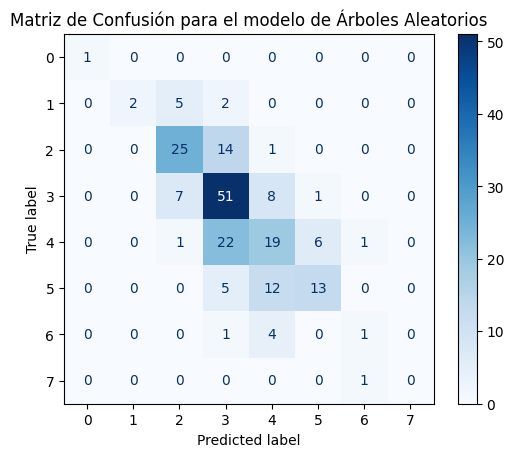

Reporte de Clasificación para el modelo de Árboles Aleatorios:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       1.00      0.22      0.36         9
           2       0.66      0.62      0.64        40
           3       0.54      0.76      0.63        67
           4       0.43      0.39      0.41        49
           5       0.65      0.43      0.52        30
           6       0.33      0.17      0.22         6
           7       0.00      0.00      0.00         1

    accuracy                           0.55       203
   macro avg       0.58      0.45      0.47       203
weighted avg       0.57      0.55      0.54       203

7/7 [==============================] - 0s 3ms/step


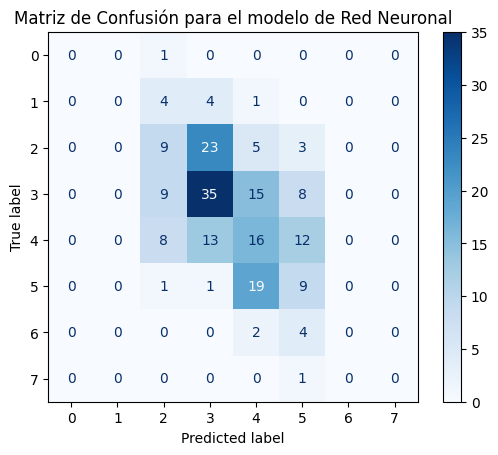

Reporte de Clasificación para el modelo de Red Neuronal:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.00      0.00      0.00         9
           2       0.28      0.23      0.25        40
           3       0.46      0.52      0.49        67
           4       0.28      0.33      0.30        49
           5       0.24      0.30      0.27        30
           6       0.00      0.00      0.00         6
           7       0.00      0.00      0.00         1

    accuracy                           0.34       203
   macro avg       0.16      0.17      0.16       203
weighted avg       0.31      0.34      0.32       203



In [ ]:
experiment = CreditRatingExperiment(file)
experiment.run()

7/7 [==============================] - 0s 3ms/step


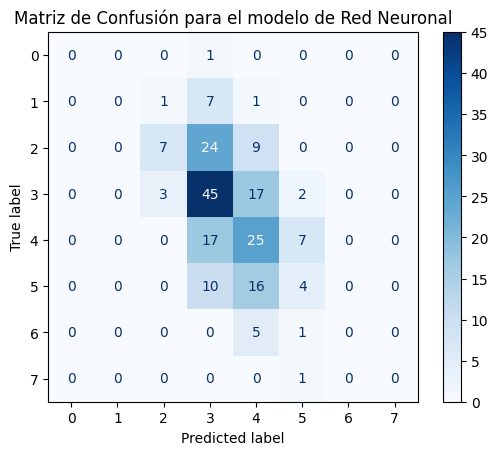

Reporte de Clasificación para el modelo de Red Neuronal:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.00      0.00      0.00         9
           2       0.64      0.17      0.27        40
           3       0.43      0.67      0.53        67
           4       0.34      0.51      0.41        49
           5       0.27      0.13      0.18        30
           6       0.00      0.00      0.00         6
           7       0.00      0.00      0.00         1

    accuracy                           0.40       203
   macro avg       0.21      0.19      0.17       203
weighted avg       0.39      0.40      0.35       203



In [ ]:
experiment = CreditRatingExperiment(file)
x_train, y_train, x_test, y_test = experiment.get_train_test_data(False, False)

experiment.run_neural_network(x_train, y_train, x_test, y_test, "mean_squared_error")

7/7 [==============================] - 0s 3ms/step


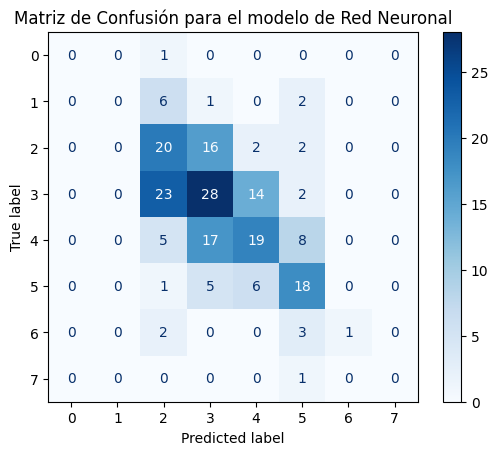

Reporte de Clasificación para el modelo de Red Neuronal:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.00      0.00      0.00         9
           2       0.34      0.50      0.41        40
           3       0.42      0.42      0.42        67
           4       0.46      0.39      0.42        49
           5       0.50      0.60      0.55        30
           6       1.00      0.17      0.29         6
           7       0.00      0.00      0.00         1

    accuracy                           0.42       203
   macro avg       0.34      0.26      0.26       203
weighted avg       0.42      0.42      0.41       203



In [ ]:
experiment = CreditRatingExperiment(file)
x_train, y_train, x_test, y_test = experiment.get_train_test_data(False, True)

experiment.run_neural_network(x_train, y_train, x_test, y_test, "mean_squared_error")

Feature 0 currentRatio: 0.015574
Feature 1 quickRatio: 0.037127
Feature 2 cashRatio: 0.036852
Feature 3 daysOfSalesOutstanding: 0.012765
Feature 4 netProfitMargin: 0.140038
Feature 5 pretaxProfitMargin: 0.166004
Feature 6 grossProfitMargin: 0.074355
Feature 7 operatingProfitMargin: 0.092733
Feature 8 returnOnAssets: 0.123303
Feature 9 returnOnCapitalEmployed: 0.130695
Feature 10 returnOnEquity: 0.086920
Feature 11 assetTurnover: 0.030133
Feature 12 fixedAssetTurnover: 0.043663
Feature 13 debtEquityRatio: 0.032060
Feature 14 debtRatio: 0.031896
Feature 15 effectiveTaxRate: 0.053285
Feature 16 freeCashFlowOperatingCashFlowRatio: 0.066537
Feature 17 freeCashFlowPerShare: 0.063017
Feature 18 cashPerShare: 0.025540
Feature 19 companyEquityMultiplier: 0.038282
Feature 20 ebitPerRevenue: 0.154775
Feature 21 enterpriseValueMultiple: 0.049864
Feature 22 operatingCashFlowPerShare: 0.108179
Feature 23 operatingCashFlowSalesRatio: 0.086987
Feature 24 payablesTurnover: 0.033621


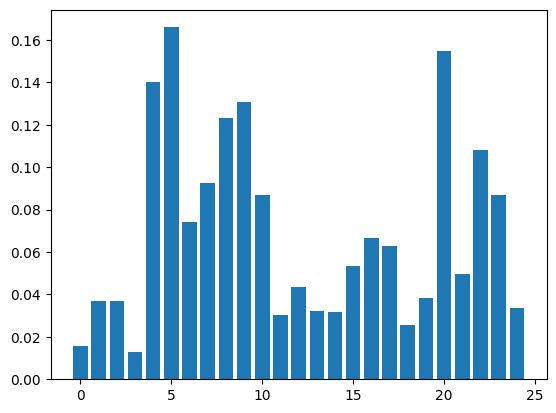

In [ ]:
fs = SelectKBest(score_func=mutual_info_classif, k=8)
# learn relationship from training data
fs.fit(x_train, y_train)
# transform train input data
X_train_fs = fs.transform(x_train)
# transform test input data
X_test_fs = fs.transform(x_test)

for i, col  in zip(range(len(fs.scores_)), x_train.columns):
  print('Feature %d %s: %f' % (i, col, fs.scores_[i]))

plt.bar([i for i in range(len(fs.scores_))], fs.scores_)
plt.show()

## Resultados


In [ ]:
experiment = CreditRatingExperiment(file)

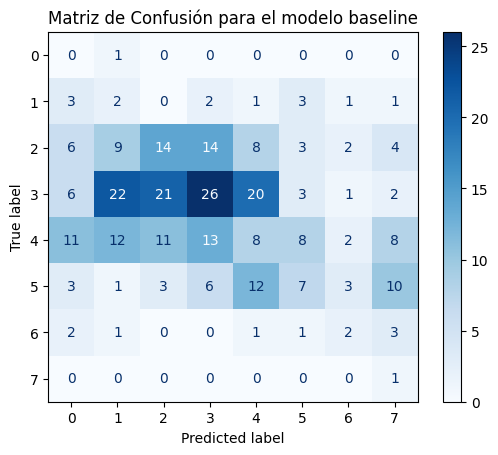

Reporte de Clasificación para el modelo baseline:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.04      0.15      0.07        13
           2       0.29      0.23      0.26        60
           3       0.43      0.26      0.32       101
           4       0.16      0.11      0.13        73
           5       0.28      0.16      0.20        45
           6       0.18      0.20      0.19        10
           7       0.03      1.00      0.07         1

    accuracy                           0.20       304
   macro avg       0.18      0.26      0.15       304
weighted avg       0.29      0.20      0.23       304



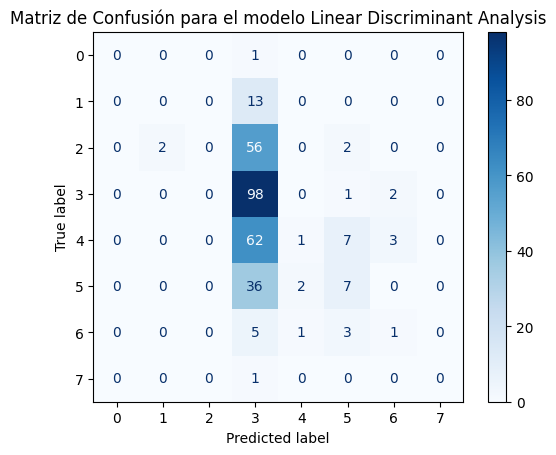

Reporte de Clasificación para el modelo Linear Discriminant Analysis:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.00      0.00      0.00        13
           2       0.00      0.00      0.00        60
           3       0.36      0.97      0.53       101
           4       0.25      0.01      0.03        73
           5       0.35      0.16      0.22        45
           6       0.17      0.10      0.12        10
           7       0.00      0.00      0.00         1

    accuracy                           0.35       304
   macro avg       0.14      0.15      0.11       304
weighted avg       0.24      0.35      0.22       304



/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


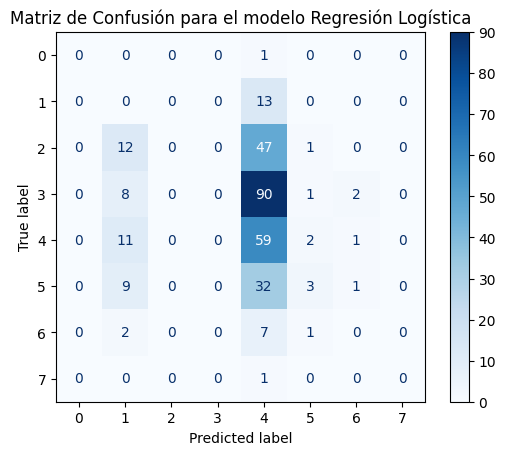

Reporte de Clasificación para el modelo Regresión Logística:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.00      0.00      0.00        13
           2       0.00      0.00      0.00        60
           3       0.00      0.00      0.00       101
           4       0.24      0.81      0.37        73
           5       0.38      0.07      0.11        45
           6       0.00      0.00      0.00        10
           7       0.00      0.00      0.00         1

    accuracy                           0.20       304
   macro avg       0.08      0.11      0.06       304
weighted avg       0.11      0.20      0.10       304



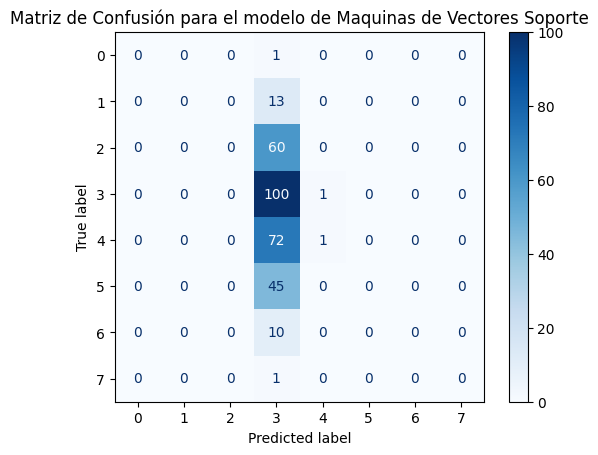

Reporte de Clasificación para el modelo de Maquinas de Vectores Soporte:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.00      0.00      0.00        13
           2       0.00      0.00      0.00        60
           3       0.33      0.99      0.50       101
           4       0.50      0.01      0.03        73
           5       0.00      0.00      0.00        45
           6       0.00      0.00      0.00        10
           7       0.00      0.00      0.00         1

    accuracy                           0.33       304
   macro avg       0.10      0.13      0.07       304
weighted avg       0.23      0.33      0.17       304



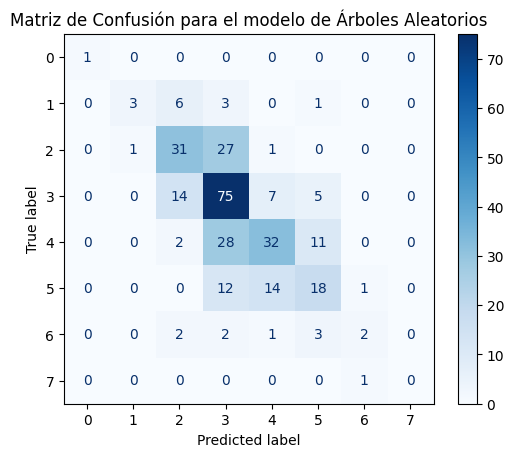

Reporte de Clasificación para el modelo de Árboles Aleatorios:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       0.75      0.23      0.35        13
           2       0.56      0.52      0.54        60
           3       0.51      0.74      0.60       101
           4       0.58      0.44      0.50        73
           5       0.47      0.40      0.43        45
           6       0.50      0.20      0.29        10
           7       0.00      0.00      0.00         1

    accuracy                           0.53       304
   macro avg       0.55      0.44      0.46       304
weighted avg       0.54      0.53      0.52       304

10/10 [==============================] - 0s 4ms/step


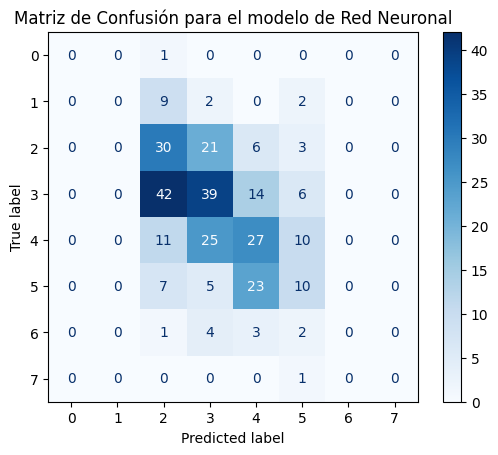

Reporte de Clasificación para el modelo de Red Neuronal:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.00      0.00      0.00        13
           2       0.30      0.50      0.37        60
           3       0.41      0.39      0.40       101
           4       0.37      0.37      0.37        73
           5       0.29      0.22      0.25        45
           6       0.00      0.00      0.00        10
           7       0.00      0.00      0.00         1

    accuracy                           0.35       304
   macro avg       0.17      0.18      0.17       304
weighted avg       0.33      0.35      0.33       304



In [ ]:
experiment.run(use_smote=False, use_scaling=False, feature_selection_method=None, test_size=0.15)

ME CAGO EN TUS MUERTOS


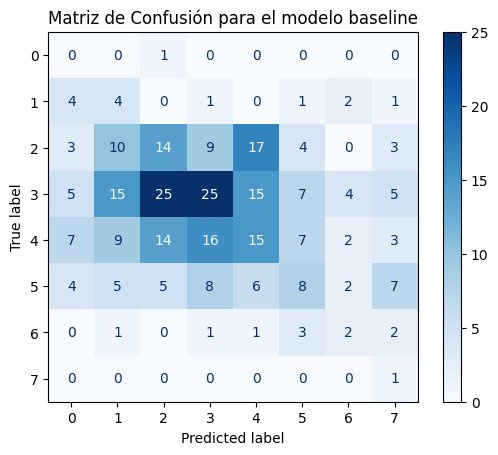

Reporte de Clasificación para el modelo baseline:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.09      0.31      0.14        13
           2       0.24      0.23      0.24        60
           3       0.42      0.25      0.31       101
           4       0.28      0.21      0.24        73
           5       0.27      0.18      0.21        45
           6       0.17      0.20      0.18        10
           7       0.05      1.00      0.09         1

    accuracy                           0.23       304
   macro avg       0.19      0.30      0.18       304
weighted avg       0.30      0.23      0.25       304



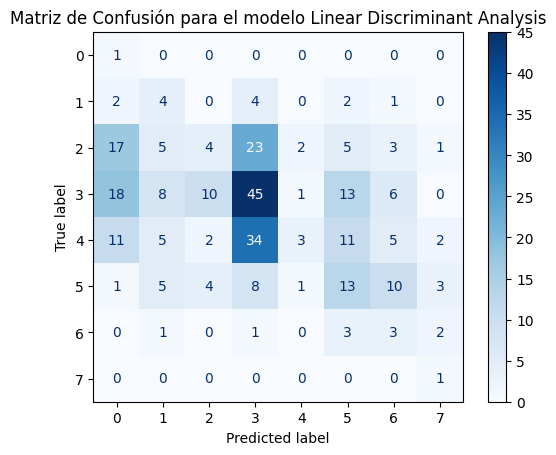

Reporte de Clasificación para el modelo Linear Discriminant Analysis:
              precision    recall  f1-score   support

           0       0.02      1.00      0.04         1
           1       0.14      0.31      0.20        13
           2       0.20      0.07      0.10        60
           3       0.39      0.45      0.42       101
           4       0.43      0.04      0.07        73
           5       0.28      0.29      0.28        45
           6       0.11      0.30      0.16        10
           7       0.11      1.00      0.20         1

    accuracy                           0.24       304
   macro avg       0.21      0.43      0.18       304
weighted avg       0.32      0.24      0.23       304



/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


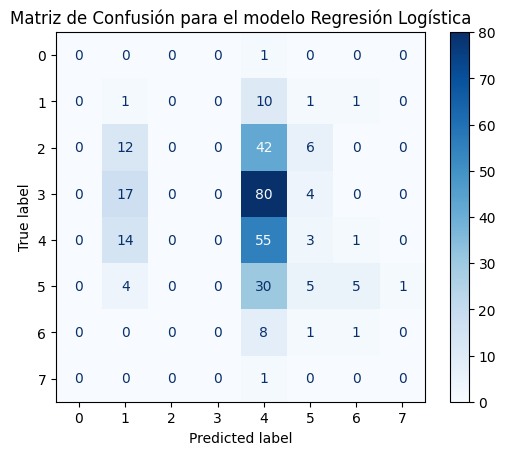

Reporte de Clasificación para el modelo Regresión Logística:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.02      0.08      0.03        13
           2       0.00      0.00      0.00        60
           3       0.00      0.00      0.00       101
           4       0.24      0.75      0.37        73
           5       0.25      0.11      0.15        45
           6       0.12      0.10      0.11        10
           7       0.00      0.00      0.00         1

    accuracy                           0.20       304
   macro avg       0.08      0.13      0.08       304
weighted avg       0.10      0.20      0.12       304



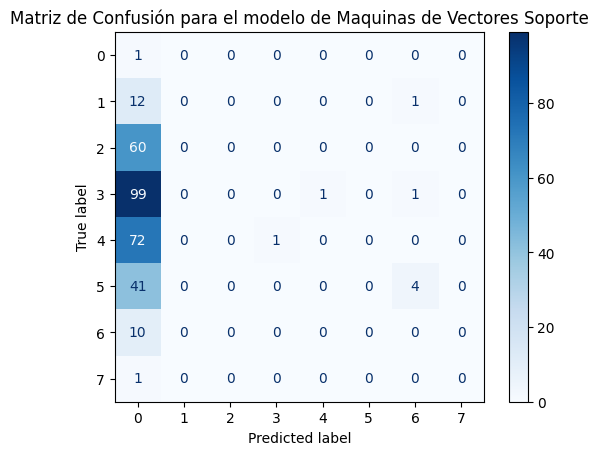

Reporte de Clasificación para el modelo de Maquinas de Vectores Soporte:
              precision    recall  f1-score   support

           0       0.00      1.00      0.01         1
           1       0.00      0.00      0.00        13
           2       0.00      0.00      0.00        60
           3       0.00      0.00      0.00       101
           4       0.00      0.00      0.00        73
           5       0.00      0.00      0.00        45
           6       0.00      0.00      0.00        10
           7       0.00      0.00      0.00         1

    accuracy                           0.00       304
   macro avg       0.00      0.12      0.00       304
weighted avg       0.00      0.00      0.00       304



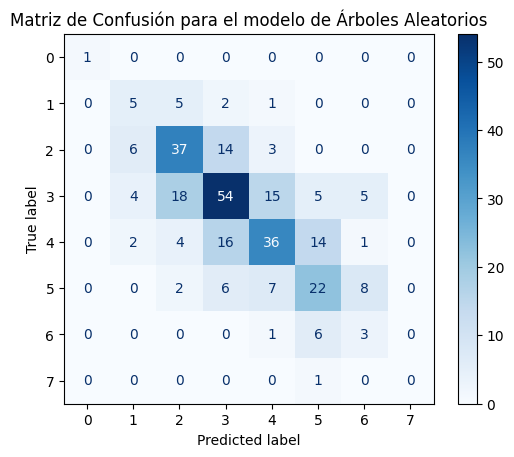

Reporte de Clasificación para el modelo de Árboles Aleatorios:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       0.29      0.38      0.33        13
           2       0.56      0.62      0.59        60
           3       0.59      0.53      0.56       101
           4       0.57      0.49      0.53        73
           5       0.46      0.49      0.47        45
           6       0.18      0.30      0.22        10
           7       0.00      0.00      0.00         1

    accuracy                           0.52       304
   macro avg       0.46      0.48      0.46       304
weighted avg       0.53      0.52      0.52       304

10/10 [==============================] - 0s 2ms/step


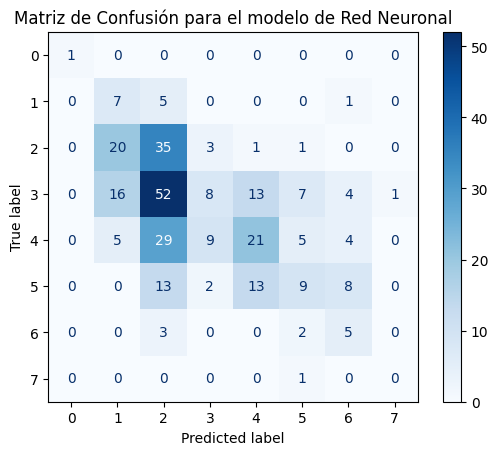

Reporte de Clasificación para el modelo de Red Neuronal:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       0.15      0.54      0.23        13
           2       0.26      0.58      0.36        60
           3       0.36      0.08      0.13       101
           4       0.44      0.29      0.35        73
           5       0.36      0.20      0.26        45
           6       0.23      0.50      0.31        10
           7       0.00      0.00      0.00         1

    accuracy                           0.28       304
   macro avg       0.35      0.40      0.33       304
weighted avg       0.35      0.28      0.26       304



In [ ]:
experiment.run(use_smote=True, use_scaling=False, feature_selection_method=None, test_size=0.15)

ME CAGO EN TUS MUERTOS


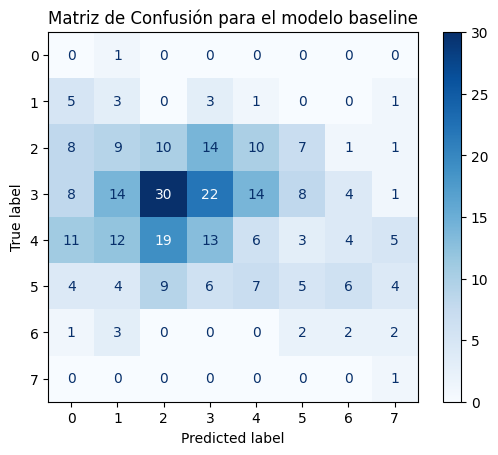

Reporte de Clasificación para el modelo baseline:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.07      0.23      0.10        13
           2       0.15      0.17      0.16        60
           3       0.38      0.22      0.28       101
           4       0.16      0.08      0.11        73
           5       0.20      0.11      0.14        45
           6       0.12      0.20      0.15        10
           7       0.07      1.00      0.12         1

    accuracy                           0.16       304
   macro avg       0.14      0.25      0.13       304
weighted avg       0.23      0.16      0.18       304



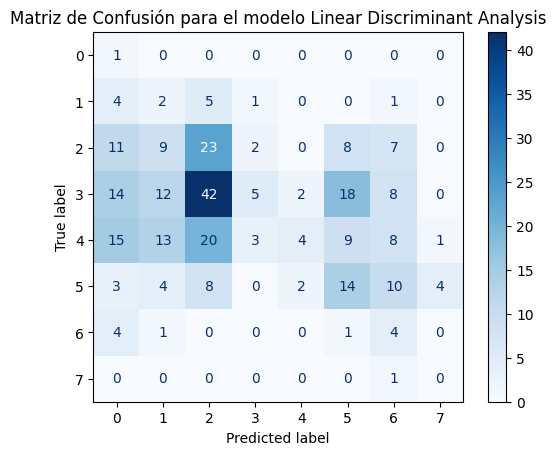

Reporte de Clasificación para el modelo Linear Discriminant Analysis:
              precision    recall  f1-score   support

           0       0.02      1.00      0.04         1
           1       0.05      0.15      0.07        13
           2       0.23      0.38      0.29        60
           3       0.45      0.05      0.09       101
           4       0.50      0.05      0.10        73
           5       0.28      0.31      0.29        45
           6       0.10      0.40      0.16        10
           7       0.00      0.00      0.00         1

    accuracy                           0.17       304
   macro avg       0.20      0.29      0.13       304
weighted avg       0.36      0.17      0.16       304



/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


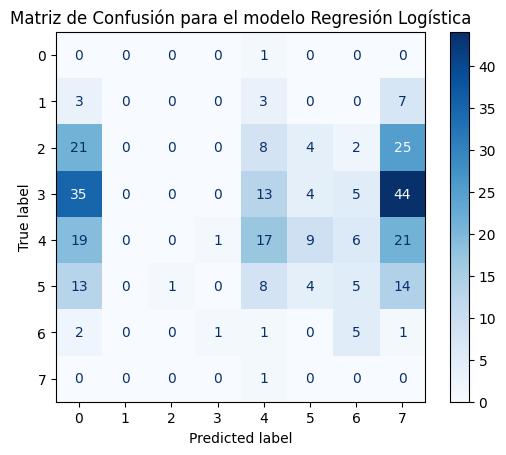

Reporte de Clasificación para el modelo Regresión Logística:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.00      0.00      0.00        13
           2       0.00      0.00      0.00        60
           3       0.00      0.00      0.00       101
           4       0.33      0.23      0.27        73
           5       0.19      0.09      0.12        45
           6       0.22      0.50      0.30        10
           7       0.00      0.00      0.00         1

    accuracy                           0.09       304
   macro avg       0.09      0.10      0.09       304
weighted avg       0.11      0.09      0.09       304



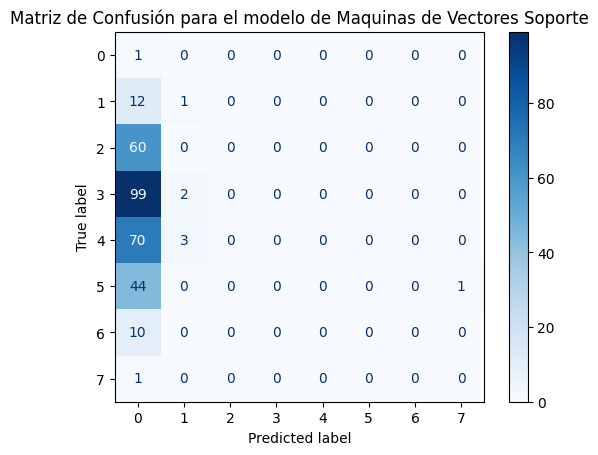

Reporte de Clasificación para el modelo de Maquinas de Vectores Soporte:
              precision    recall  f1-score   support

           0       0.00      1.00      0.01         1
           1       0.17      0.08      0.11        13
           2       0.00      0.00      0.00        60
           3       0.00      0.00      0.00       101
           4       0.00      0.00      0.00        73
           5       0.00      0.00      0.00        45
           6       0.00      0.00      0.00        10
           7       0.00      0.00      0.00         1

    accuracy                           0.01       304
   macro avg       0.02      0.13      0.01       304
weighted avg       0.01      0.01      0.00       304



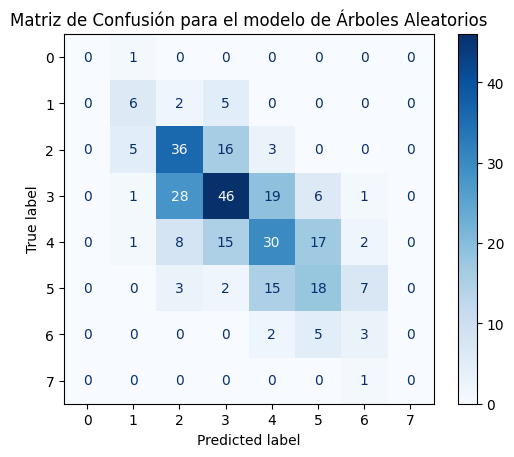

Reporte de Clasificación para el modelo de Árboles Aleatorios:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.43      0.46      0.44        13
           2       0.47      0.60      0.53        60
           3       0.55      0.46      0.50       101
           4       0.43      0.41      0.42        73
           5       0.39      0.40      0.40        45
           6       0.21      0.30      0.25        10
           7       0.00      0.00      0.00         1

    accuracy                           0.46       304
   macro avg       0.31      0.33      0.32       304
weighted avg       0.46      0.46      0.46       304

10/10 [==============================] - 0s 2ms/step


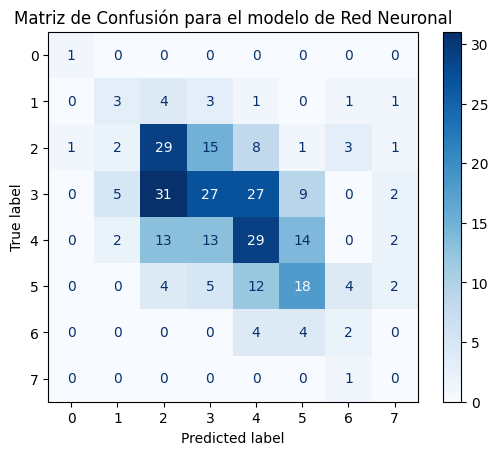

Reporte de Clasificación para el modelo de Red Neuronal:
              precision    recall  f1-score   support

           0       0.50      1.00      0.67         1
           1       0.25      0.23      0.24        13
           2       0.36      0.48      0.41        60
           3       0.43      0.27      0.33       101
           4       0.36      0.40      0.38        73
           5       0.39      0.40      0.40        45
           6       0.18      0.20      0.19        10
           7       0.00      0.00      0.00         1

    accuracy                           0.36       304
   macro avg       0.31      0.37      0.33       304
weighted avg       0.38      0.36      0.36       304



In [ ]:
experiment.run(use_smote=True, use_scaling=True, feature_selection_method=None, test_size=0.15)

['currentRatio' 'daysOfSalesOutstanding' 'netProfitMargin'
 'grossProfitMargin' 'debtRatio' 'freeCashFlowOperatingCashFlowRatio'
 'enterpriseValueMultiple' 'operatingCashFlowSalesRatio']


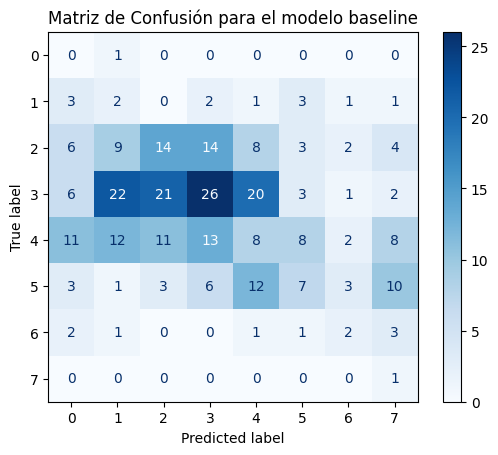

Reporte de Clasificación para el modelo baseline:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.04      0.15      0.07        13
           2       0.29      0.23      0.26        60
           3       0.43      0.26      0.32       101
           4       0.16      0.11      0.13        73
           5       0.28      0.16      0.20        45
           6       0.18      0.20      0.19        10
           7       0.03      1.00      0.07         1

    accuracy                           0.20       304
   macro avg       0.18      0.26      0.15       304
weighted avg       0.29      0.20      0.23       304



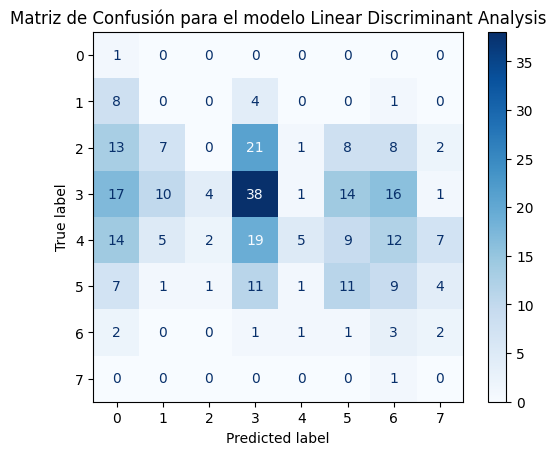

Reporte de Clasificación para el modelo Linear Discriminant Analysis:
              precision    recall  f1-score   support

           0       0.02      1.00      0.03         1
           1       0.00      0.00      0.00        13
           2       0.00      0.00      0.00        60
           3       0.40      0.38      0.39       101
           4       0.56      0.07      0.12        73
           5       0.26      0.24      0.25        45
           6       0.06      0.30      0.10        10
           7       0.00      0.00      0.00         1

    accuracy                           0.19       304
   macro avg       0.16      0.25      0.11       304
weighted avg       0.31      0.19      0.20       304



/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


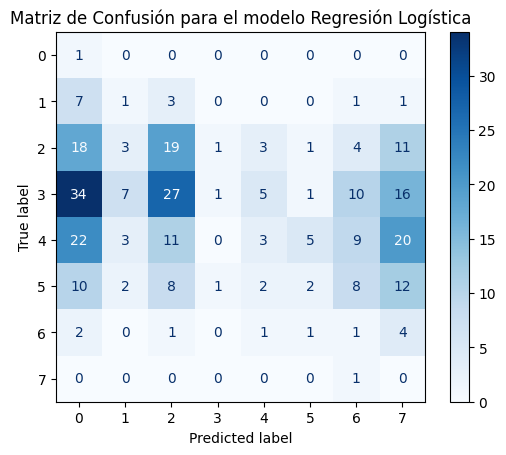

Reporte de Clasificación para el modelo Regresión Logística:
              precision    recall  f1-score   support

           0       0.01      1.00      0.02         1
           1       0.06      0.08      0.07        13
           2       0.28      0.32      0.29        60
           3       0.33      0.01      0.02       101
           4       0.21      0.04      0.07        73
           5       0.20      0.04      0.07        45
           6       0.03      0.10      0.05        10
           7       0.00      0.00      0.00         1

    accuracy                           0.09       304
   macro avg       0.14      0.20      0.07       304
weighted avg       0.25      0.09      0.10       304



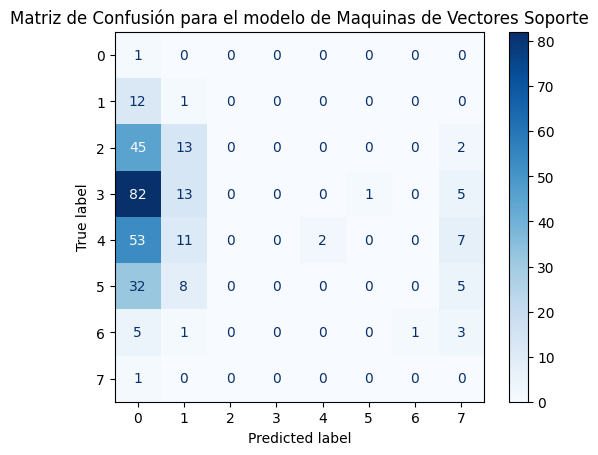

Reporte de Clasificación para el modelo de Maquinas de Vectores Soporte:
              precision    recall  f1-score   support

           0       0.00      1.00      0.01         1
           1       0.02      0.08      0.03        13
           2       0.00      0.00      0.00        60
           3       0.00      0.00      0.00       101
           4       1.00      0.03      0.05        73
           5       0.00      0.00      0.00        45
           6       1.00      0.10      0.18        10
           7       0.00      0.00      0.00         1

    accuracy                           0.02       304
   macro avg       0.25      0.15      0.03       304
weighted avg       0.27      0.02      0.02       304



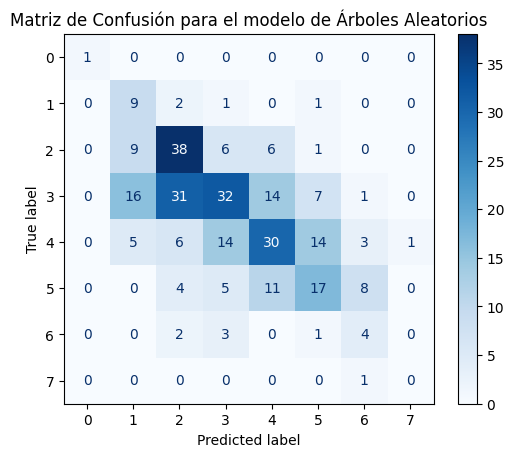

Reporte de Clasificación para el modelo de Árboles Aleatorios:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       0.23      0.69      0.35        13
           2       0.46      0.63      0.53        60
           3       0.52      0.32      0.40       101
           4       0.49      0.41      0.45        73
           5       0.41      0.38      0.40        45
           6       0.24      0.40      0.30        10
           7       0.00      0.00      0.00         1

    accuracy                           0.43       304
   macro avg       0.42      0.48      0.43       304
weighted avg       0.47      0.43      0.43       304

10/10 [==============================] - 0s 2ms/step


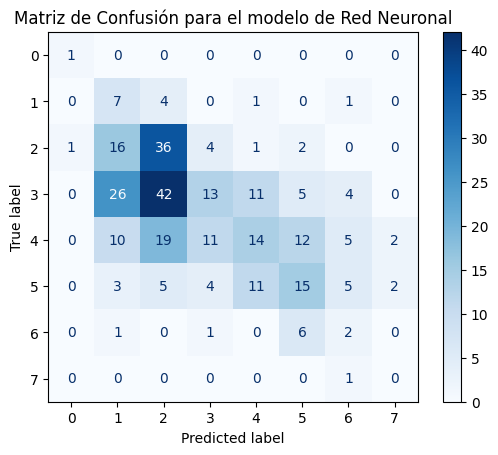

Reporte de Clasificación para el modelo de Red Neuronal:
              precision    recall  f1-score   support

           0       0.50      1.00      0.67         1
           1       0.11      0.54      0.18        13
           2       0.34      0.60      0.43        60
           3       0.39      0.13      0.19       101
           4       0.37      0.19      0.25        73
           5       0.38      0.33      0.35        45
           6       0.11      0.20      0.14        10
           7       0.00      0.00      0.00         1

    accuracy                           0.29       304
   macro avg       0.27      0.37      0.28       304
weighted avg       0.35      0.29      0.28       304



In [ ]:
experiment.run(use_smote=True, use_scaling=True, feature_selection_method='ANOVA', test_size=0.15)

['currentRatio' 'cashRatio' 'netProfitMargin' 'returnOnEquity' 'debtRatio'
 'freeCashFlowOperatingCashFlowRatio' 'companyEquityMultiplier'
 'enterpriseValueMultiple']


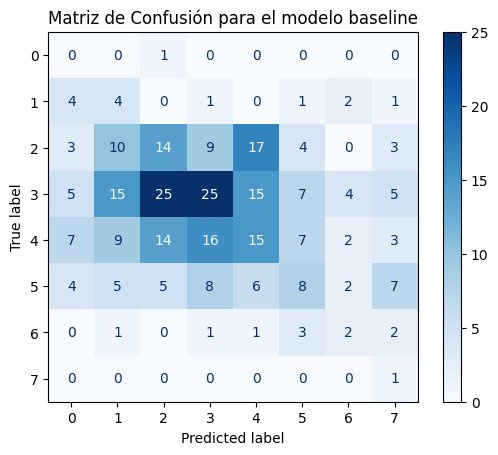

Reporte de Clasificación para el modelo baseline:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.09      0.31      0.14        13
           2       0.24      0.23      0.24        60
           3       0.42      0.25      0.31       101
           4       0.28      0.21      0.24        73
           5       0.27      0.18      0.21        45
           6       0.17      0.20      0.18        10
           7       0.05      1.00      0.09         1

    accuracy                           0.23       304
   macro avg       0.19      0.30      0.18       304
weighted avg       0.30      0.23      0.25       304



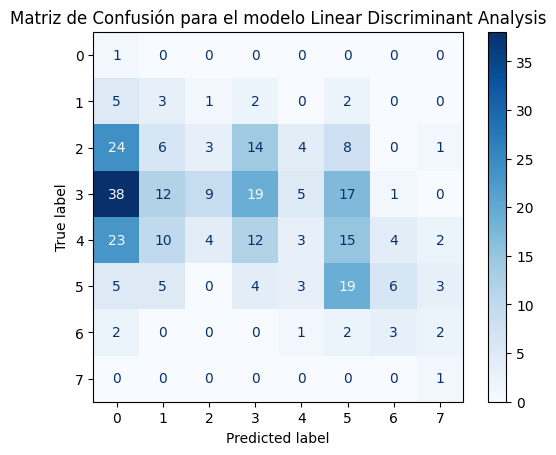

Reporte de Clasificación para el modelo Linear Discriminant Analysis:
              precision    recall  f1-score   support

           0       0.01      1.00      0.02         1
           1       0.08      0.23      0.12        13
           2       0.18      0.05      0.08        60
           3       0.37      0.19      0.25       101
           4       0.19      0.04      0.07        73
           5       0.30      0.42      0.35        45
           6       0.21      0.30      0.25        10
           7       0.11      1.00      0.20         1

    accuracy                           0.17       304
   macro avg       0.18      0.40      0.17       304
weighted avg       0.26      0.17      0.18       304



/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


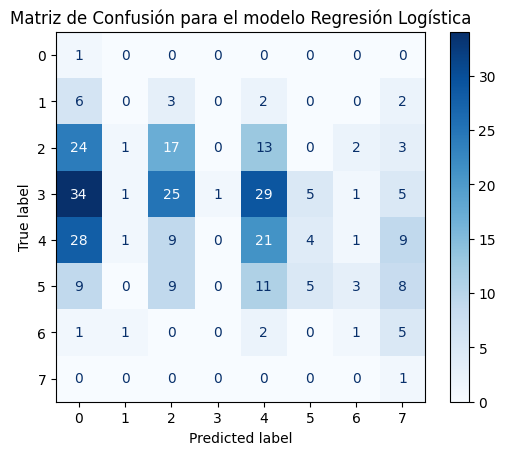

Reporte de Clasificación para el modelo Regresión Logística:
              precision    recall  f1-score   support

           0       0.01      1.00      0.02         1
           1       0.00      0.00      0.00        13
           2       0.27      0.28      0.28        60
           3       1.00      0.01      0.02       101
           4       0.27      0.29      0.28        73
           5       0.36      0.11      0.17        45
           6       0.12      0.10      0.11        10
           7       0.03      1.00      0.06         1

    accuracy                           0.15       304
   macro avg       0.26      0.35      0.12       304
weighted avg       0.51      0.15      0.16       304



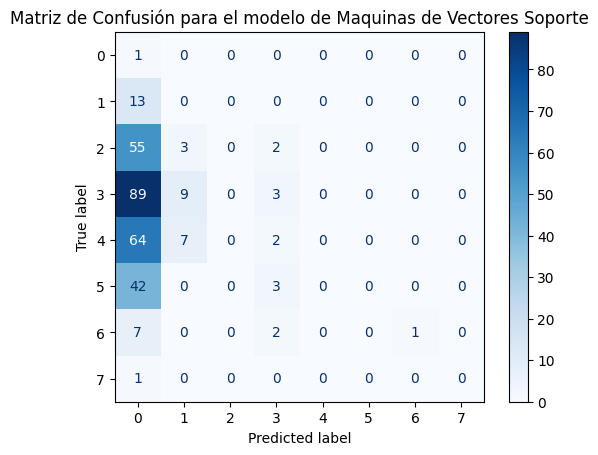

Reporte de Clasificación para el modelo de Maquinas de Vectores Soporte:
              precision    recall  f1-score   support

           0       0.00      1.00      0.01         1
           1       0.00      0.00      0.00        13
           2       0.00      0.00      0.00        60
           3       0.25      0.03      0.05       101
           4       0.00      0.00      0.00        73
           5       0.00      0.00      0.00        45
           6       1.00      0.10      0.18        10
           7       0.00      0.00      0.00         1

    accuracy                           0.02       304
   macro avg       0.16      0.14      0.03       304
weighted avg       0.12      0.02      0.02       304



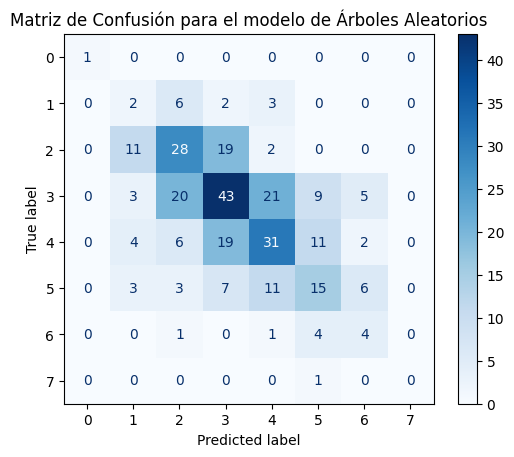

Reporte de Clasificación para el modelo de Árboles Aleatorios:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       0.09      0.15      0.11        13
           2       0.44      0.47      0.45        60
           3       0.48      0.43      0.45       101
           4       0.45      0.42      0.44        73
           5       0.38      0.33      0.35        45
           6       0.24      0.40      0.30        10
           7       0.00      0.00      0.00         1

    accuracy                           0.41       304
   macro avg       0.38      0.40      0.39       304
weighted avg       0.42      0.41      0.41       304

10/10 [==============================] - 0s 2ms/step


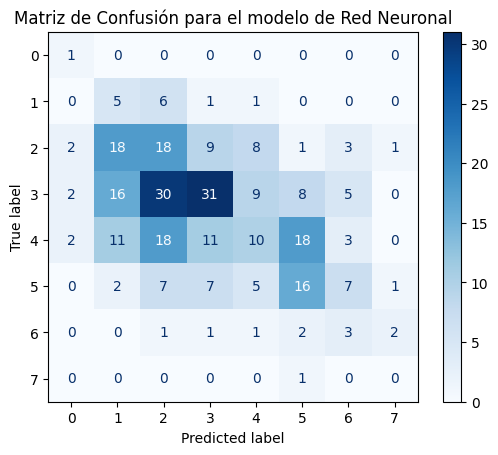

Reporte de Clasificación para el modelo de Red Neuronal:
              precision    recall  f1-score   support

           0       0.14      1.00      0.25         1
           1       0.10      0.38      0.15        13
           2       0.23      0.30      0.26        60
           3       0.52      0.31      0.39       101
           4       0.29      0.14      0.19        73
           5       0.35      0.36      0.35        45
           6       0.14      0.30      0.19        10
           7       0.00      0.00      0.00         1

    accuracy                           0.28       304
   macro avg       0.22      0.35      0.22       304
weighted avg       0.35      0.28      0.29       304



In [ ]:
experiment.run(use_smote=True, use_scaling=True, feature_selection_method='mutual_information', test_size=0.15)

['returnOnAssets' 'returnOnCapitalEmployed' 'returnOnEquity'
 'assetTurnover' 'fixedAssetTurnover' 'debtEquityRatio' 'debtRatio'
 'companyEquityMultiplier']


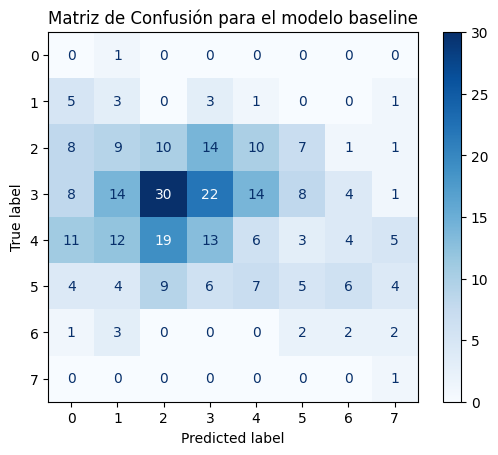

Reporte de Clasificación para el modelo baseline:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.07      0.23      0.10        13
           2       0.15      0.17      0.16        60
           3       0.38      0.22      0.28       101
           4       0.16      0.08      0.11        73
           5       0.20      0.11      0.14        45
           6       0.12      0.20      0.15        10
           7       0.07      1.00      0.12         1

    accuracy                           0.16       304
   macro avg       0.14      0.25      0.13       304
weighted avg       0.23      0.16      0.18       304



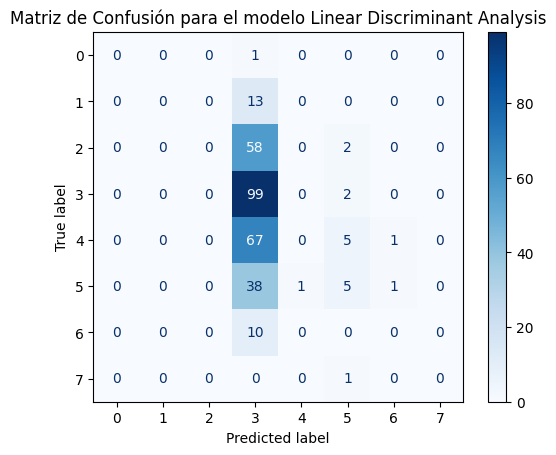

Reporte de Clasificación para el modelo Linear Discriminant Analysis:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.00      0.00      0.00        13
           2       0.00      0.00      0.00        60
           3       0.35      0.98      0.51       101
           4       0.00      0.00      0.00        73
           5       0.33      0.11      0.17        45
           6       0.00      0.00      0.00        10
           7       0.00      0.00      0.00         1

    accuracy                           0.34       304
   macro avg       0.08      0.14      0.08       304
weighted avg       0.16      0.34      0.19       304



/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


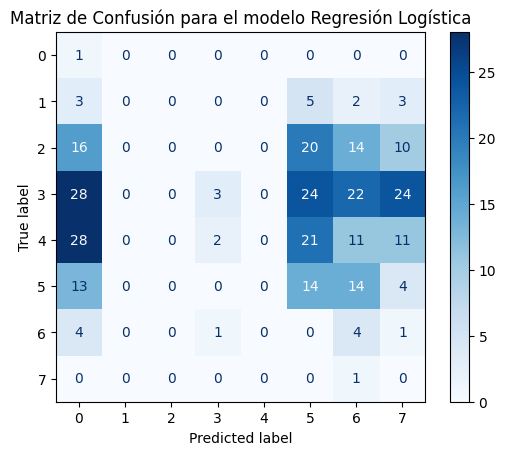

Reporte de Clasificación para el modelo Regresión Logística:
              precision    recall  f1-score   support

           0       0.01      1.00      0.02         1
           1       0.00      0.00      0.00        13
           2       0.00      0.00      0.00        60
           3       0.50      0.03      0.06       101
           4       0.00      0.00      0.00        73
           5       0.17      0.31      0.22        45
           6       0.06      0.40      0.10        10
           7       0.00      0.00      0.00         1

    accuracy                           0.07       304
   macro avg       0.09      0.22      0.05       304
weighted avg       0.19      0.07      0.05       304



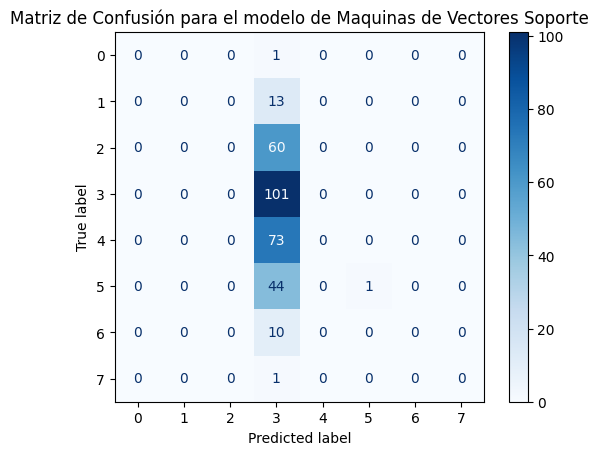

Reporte de Clasificación para el modelo de Maquinas de Vectores Soporte:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.00      0.00      0.00        13
           2       0.00      0.00      0.00        60
           3       0.33      1.00      0.50       101
           4       0.00      0.00      0.00        73
           5       1.00      0.02      0.04        45
           6       0.00      0.00      0.00        10
           7       0.00      0.00      0.00         1

    accuracy                           0.34       304
   macro avg       0.17      0.13      0.07       304
weighted avg       0.26      0.34      0.17       304



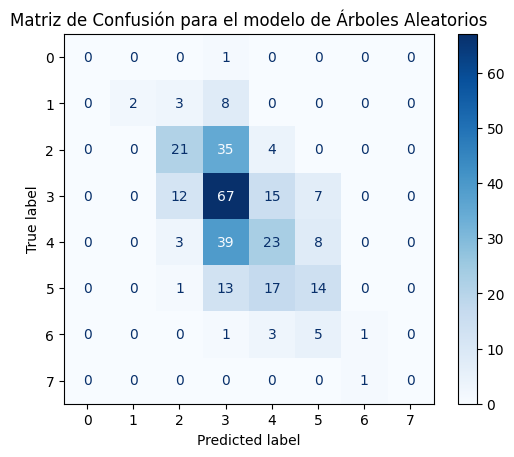

Reporte de Clasificación para el modelo de Árboles Aleatorios:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       1.00      0.15      0.27        13
           2       0.53      0.35      0.42        60
           3       0.41      0.66      0.51       101
           4       0.37      0.32      0.34        73
           5       0.41      0.31      0.35        45
           6       0.50      0.10      0.17        10
           7       0.00      0.00      0.00         1

    accuracy                           0.42       304
   macro avg       0.40      0.24      0.26       304
weighted avg       0.45      0.42      0.40       304

10/10 [==============================] - 0s 2ms/step


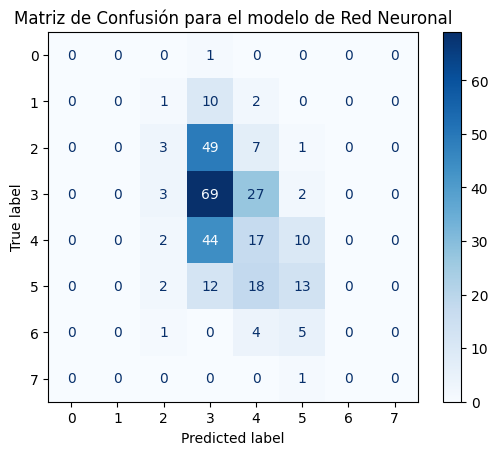

Reporte de Clasificación para el modelo de Red Neuronal:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.00      0.00      0.00        13
           2       0.25      0.05      0.08        60
           3       0.37      0.68      0.48       101
           4       0.23      0.23      0.23        73
           5       0.41      0.29      0.34        45
           6       0.00      0.00      0.00        10
           7       0.00      0.00      0.00         1

    accuracy                           0.34       304
   macro avg       0.16      0.16      0.14       304
weighted avg       0.29      0.34      0.28       304



In [ ]:
experiment.run(use_smote=False, use_scaling=True, feature_selection_method='ANOVA', test_size=0.15)

['quickRatio' 'pretaxProfitMargin' 'fixedAssetTurnover'
 'freeCashFlowOperatingCashFlowRatio' 'ebitPerRevenue'
 'operatingCashFlowPerShare' 'operatingCashFlowSalesRatio'
 'payablesTurnover']


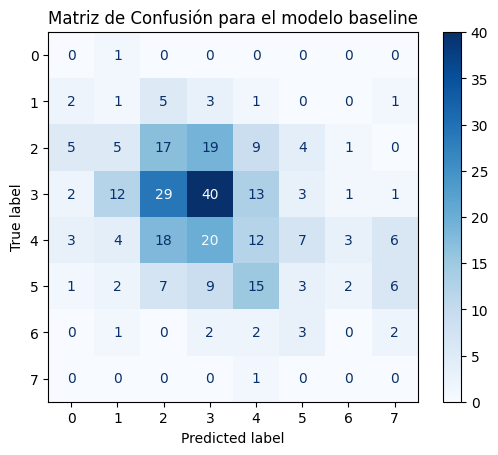

Reporte de Clasificación para el modelo baseline:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.04      0.08      0.05        13
           2       0.22      0.28      0.25        60
           3       0.43      0.40      0.41       101
           4       0.23      0.16      0.19        73
           5       0.15      0.07      0.09        45
           6       0.00      0.00      0.00        10
           7       0.00      0.00      0.00         1

    accuracy                           0.24       304
   macro avg       0.13      0.12      0.12       304
weighted avg       0.27      0.24      0.25       304



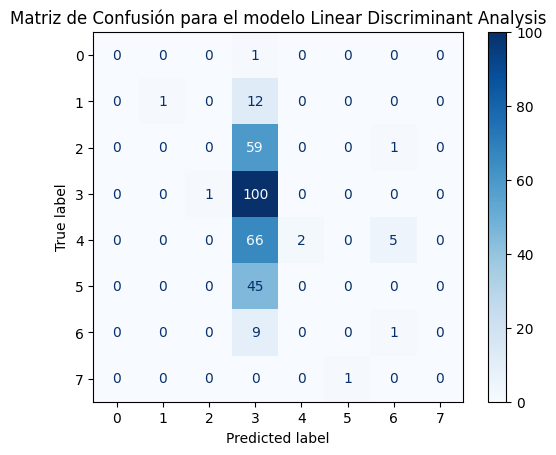

Reporte de Clasificación para el modelo Linear Discriminant Analysis:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       1.00      0.08      0.14        13
           2       0.00      0.00      0.00        60
           3       0.34      0.99      0.51       101
           4       1.00      0.03      0.05        73
           5       0.00      0.00      0.00        45
           6       0.14      0.10      0.12        10
           7       0.00      0.00      0.00         1

    accuracy                           0.34       304
   macro avg       0.31      0.15      0.10       304
weighted avg       0.40      0.34      0.19       304



/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


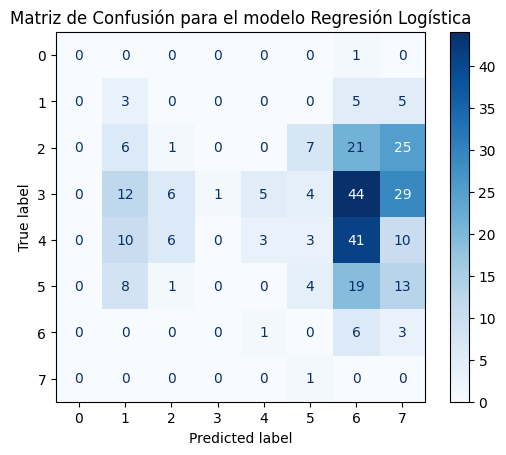

Reporte de Clasificación para el modelo Regresión Logística:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.08      0.23      0.12        13
           2       0.07      0.02      0.03        60
           3       1.00      0.01      0.02       101
           4       0.33      0.04      0.07        73
           5       0.21      0.09      0.12        45
           6       0.04      0.60      0.08        10
           7       0.00      0.00      0.00         1

    accuracy                           0.06       304
   macro avg       0.22      0.12      0.06       304
weighted avg       0.46      0.06      0.06       304



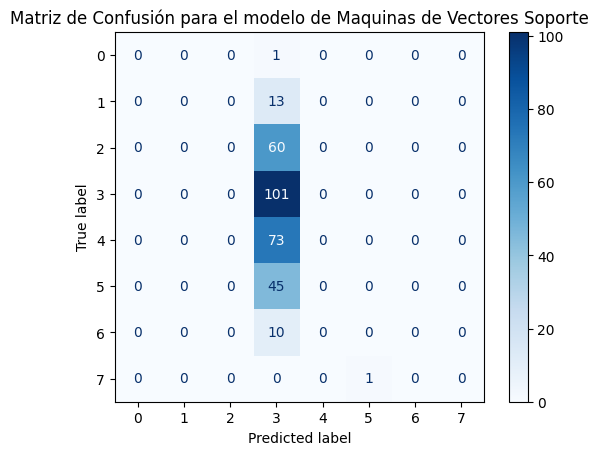

Reporte de Clasificación para el modelo de Maquinas de Vectores Soporte:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.00      0.00      0.00        13
           2       0.00      0.00      0.00        60
           3       0.33      1.00      0.50       101
           4       0.00      0.00      0.00        73
           5       0.00      0.00      0.00        45
           6       0.00      0.00      0.00        10
           7       0.00      0.00      0.00         1

    accuracy                           0.33       304
   macro avg       0.04      0.12      0.06       304
weighted avg       0.11      0.33      0.17       304



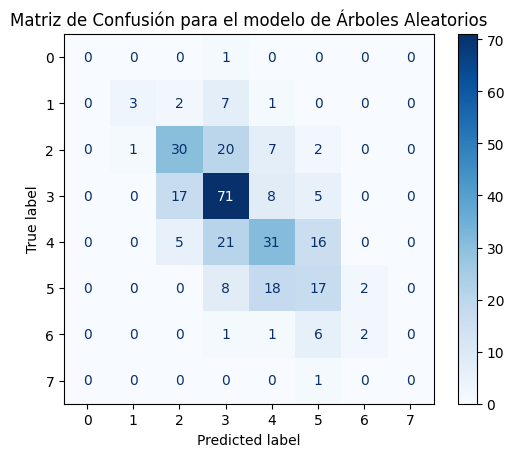

Reporte de Clasificación para el modelo de Árboles Aleatorios:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.75      0.23      0.35        13
           2       0.56      0.50      0.53        60
           3       0.55      0.70      0.62       101
           4       0.47      0.42      0.45        73
           5       0.36      0.38      0.37        45
           6       0.50      0.20      0.29        10
           7       0.00      0.00      0.00         1

    accuracy                           0.51       304
   macro avg       0.40      0.30      0.32       304
weighted avg       0.51      0.51      0.50       304

10/10 [==============================] - 0s 3ms/step


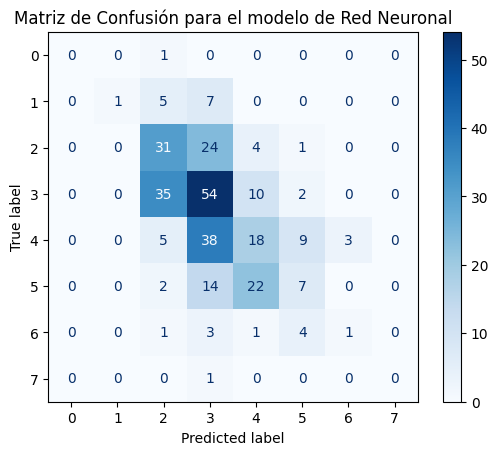

Reporte de Clasificación para el modelo de Red Neuronal:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       1.00      0.08      0.14        13
           2       0.39      0.52      0.44        60
           3       0.38      0.53      0.45       101
           4       0.33      0.25      0.28        73
           5       0.30      0.16      0.21        45
           6       0.25      0.10      0.14        10
           7       0.00      0.00      0.00         1

    accuracy                           0.37       304
   macro avg       0.33      0.20      0.21       304
weighted avg       0.38      0.37      0.34       304



In [ ]:
experiment.run(use_smote=False, use_scaling=True, feature_selection_method='mutual_information', test_size=0.15)

['currentRatio' 'quickRatio' 'grossProfitMargin' 'returnOnEquity'
 'debtEquityRatio' 'debtRatio' 'effectiveTaxRate'
 'companyEquityMultiplier']


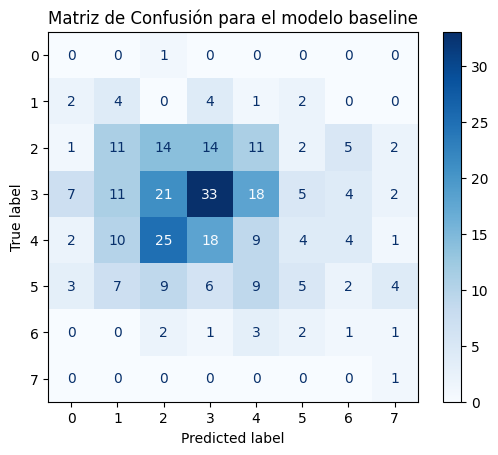

Reporte de Clasificación para el modelo baseline:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.09      0.31      0.14        13
           2       0.19      0.23      0.21        60
           3       0.43      0.33      0.37       101
           4       0.18      0.12      0.15        73
           5       0.25      0.11      0.15        45
           6       0.06      0.10      0.08        10
           7       0.09      1.00      0.17         1

    accuracy                           0.22       304
   macro avg       0.16      0.28      0.16       304
weighted avg       0.27      0.22      0.23       304



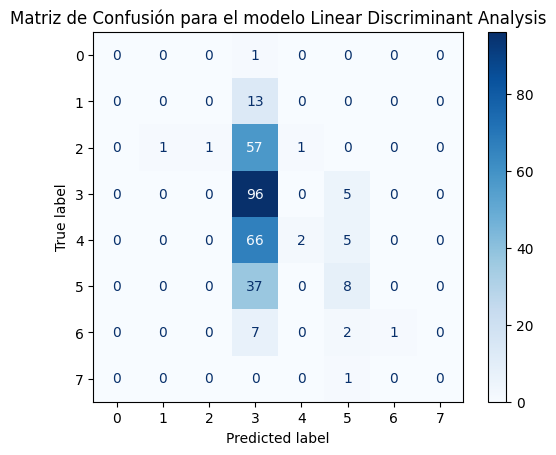

Reporte de Clasificación para el modelo Linear Discriminant Analysis:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.00      0.00      0.00        13
           2       1.00      0.02      0.03        60
           3       0.35      0.95      0.51       101
           4       0.67      0.03      0.05        73
           5       0.38      0.18      0.24        45
           6       1.00      0.10      0.18        10
           7       0.00      0.00      0.00         1

    accuracy                           0.36       304
   macro avg       0.42      0.16      0.13       304
weighted avg       0.56      0.36      0.23       304



/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


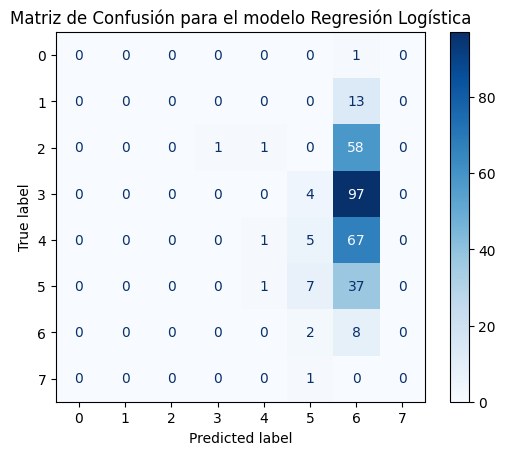

Reporte de Clasificación para el modelo Regresión Logística:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.00      0.00      0.00        13
           2       0.00      0.00      0.00        60
           3       0.00      0.00      0.00       101
           4       0.33      0.01      0.03        73
           5       0.37      0.16      0.22        45
           6       0.03      0.80      0.05        10
           7       0.00      0.00      0.00         1

    accuracy                           0.05       304
   macro avg       0.09      0.12      0.04       304
weighted avg       0.14      0.05      0.04       304



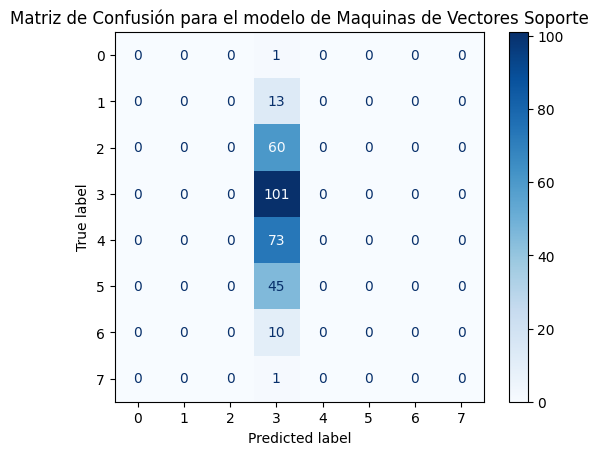

Reporte de Clasificación para el modelo de Maquinas de Vectores Soporte:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.00      0.00      0.00        13
           2       0.00      0.00      0.00        60
           3       0.33      1.00      0.50       101
           4       0.00      0.00      0.00        73
           5       0.00      0.00      0.00        45
           6       0.00      0.00      0.00        10
           7       0.00      0.00      0.00         1

    accuracy                           0.33       304
   macro avg       0.04      0.12      0.06       304
weighted avg       0.11      0.33      0.17       304



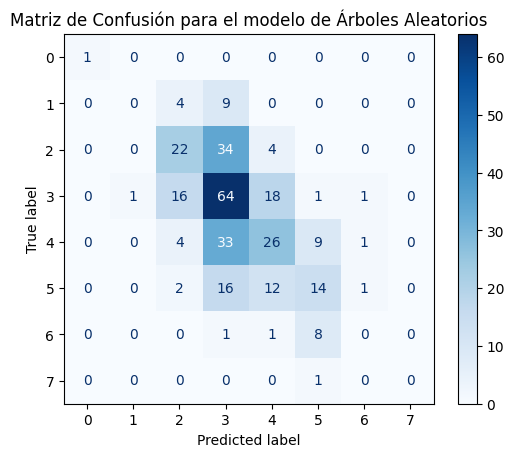

Reporte de Clasificación para el modelo de Árboles Aleatorios:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       0.00      0.00      0.00        13
           2       0.46      0.37      0.41        60
           3       0.41      0.63      0.50       101
           4       0.43      0.36      0.39        73
           5       0.42      0.31      0.36        45
           6       0.00      0.00      0.00        10
           7       0.00      0.00      0.00         1

    accuracy                           0.42       304
   macro avg       0.34      0.33      0.33       304
weighted avg       0.39      0.42      0.39       304

10/10 [==============================] - 0s 2ms/step


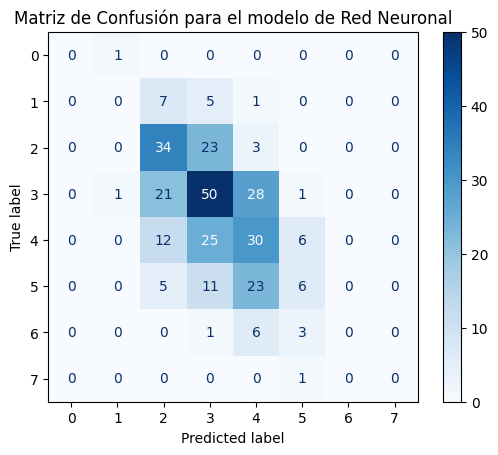

Reporte de Clasificación para el modelo de Red Neuronal:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.00      0.00      0.00        13
           2       0.43      0.57      0.49        60
           3       0.43      0.50      0.46       101
           4       0.33      0.41      0.37        73
           5       0.35      0.13      0.19        45
           6       0.00      0.00      0.00        10
           7       0.00      0.00      0.00         1

    accuracy                           0.39       304
   macro avg       0.19      0.20      0.19       304
weighted avg       0.36      0.39      0.37       304



In [ ]:
 experiment.run(use_smote=False, use_scaling=False, feature_selection_method='ANOVA', test_size=0.15)

['cashRatio' 'daysOfSalesOutstanding' 'netProfitMargin' 'returnOnAssets'
 'returnOnCapitalEmployed' 'fixedAssetTurnover'
 'operatingCashFlowSalesRatio' 'payablesTurnover']


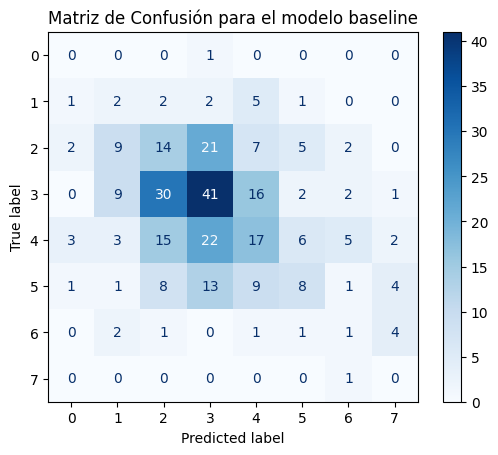

Reporte de Clasificación para el modelo baseline:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.08      0.15      0.10        13
           2       0.20      0.23      0.22        60
           3       0.41      0.41      0.41       101
           4       0.31      0.23      0.27        73
           5       0.35      0.18      0.24        45
           6       0.08      0.10      0.09        10
           7       0.00      0.00      0.00         1

    accuracy                           0.27       304
   macro avg       0.18      0.16      0.16       304
weighted avg       0.31      0.27      0.28       304



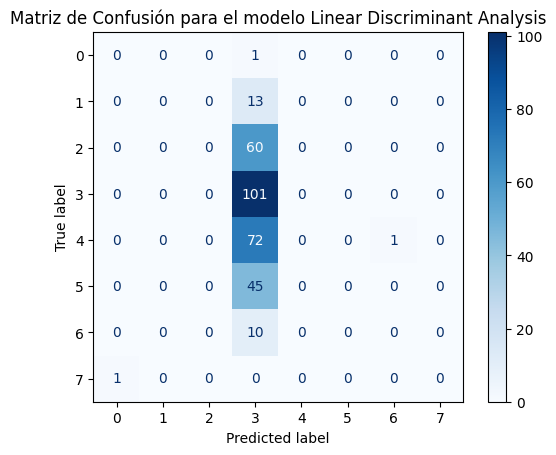

Reporte de Clasificación para el modelo Linear Discriminant Analysis:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.00      0.00      0.00        13
           2       0.00      0.00      0.00        60
           3       0.33      1.00      0.50       101
           4       0.00      0.00      0.00        73
           5       0.00      0.00      0.00        45
           6       0.00      0.00      0.00        10
           7       0.00      0.00      0.00         1

    accuracy                           0.33       304
   macro avg       0.04      0.12      0.06       304
weighted avg       0.11      0.33      0.17       304



/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


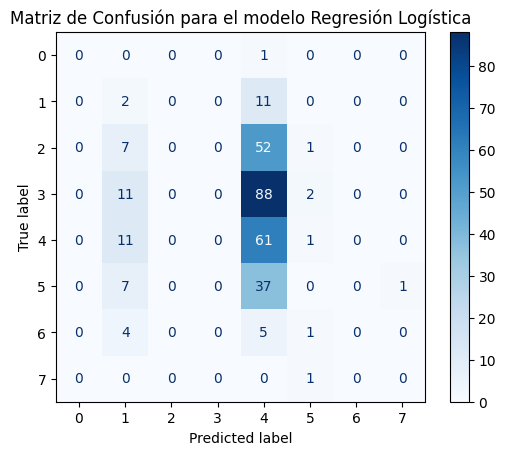

Reporte de Clasificación para el modelo Regresión Logística:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.05      0.15      0.07        13
           2       0.00      0.00      0.00        60
           3       0.00      0.00      0.00       101
           4       0.24      0.84      0.37        73
           5       0.00      0.00      0.00        45
           6       0.00      0.00      0.00        10
           7       0.00      0.00      0.00         1

    accuracy                           0.21       304
   macro avg       0.04      0.12      0.06       304
weighted avg       0.06      0.21      0.09       304



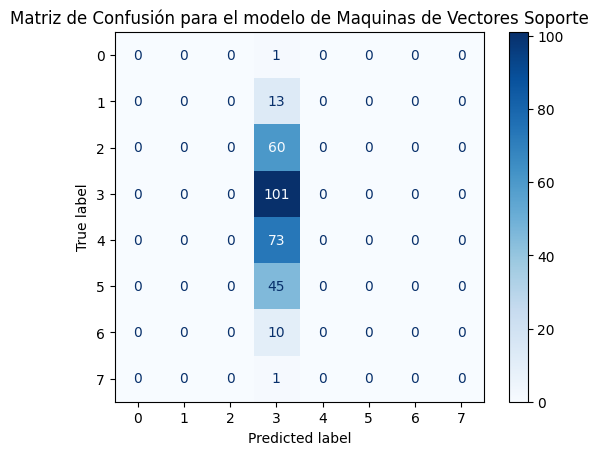

Reporte de Clasificación para el modelo de Maquinas de Vectores Soporte:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.00      0.00      0.00        13
           2       0.00      0.00      0.00        60
           3       0.33      1.00      0.50       101
           4       0.00      0.00      0.00        73
           5       0.00      0.00      0.00        45
           6       0.00      0.00      0.00        10
           7       0.00      0.00      0.00         1

    accuracy                           0.33       304
   macro avg       0.04      0.12      0.06       304
weighted avg       0.11      0.33      0.17       304



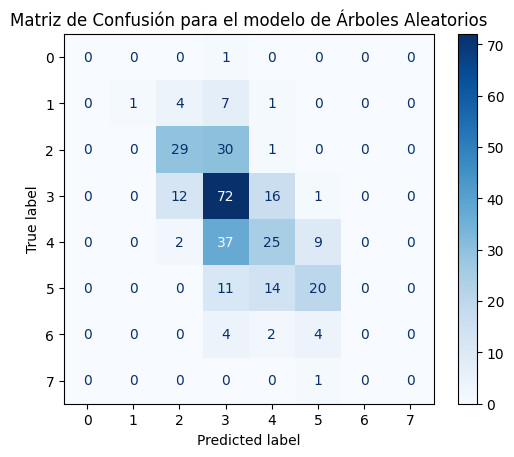

Reporte de Clasificación para el modelo de Árboles Aleatorios:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       1.00      0.08      0.14        13
           2       0.62      0.48      0.54        60
           3       0.44      0.71      0.55       101
           4       0.42      0.34      0.38        73
           5       0.57      0.44      0.50        45
           6       0.00      0.00      0.00        10
           7       0.00      0.00      0.00         1

    accuracy                           0.48       304
   macro avg       0.38      0.26      0.26       304
weighted avg       0.50      0.48      0.46       304

10/10 [==============================] - 0s 3ms/step


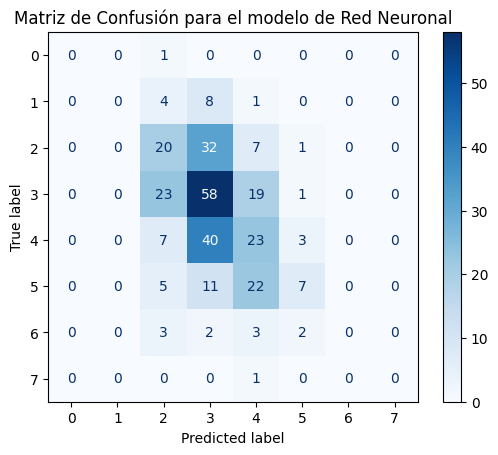

Reporte de Clasificación para el modelo de Red Neuronal:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.00      0.00      0.00        13
           2       0.32      0.33      0.33        60
           3       0.38      0.57      0.46       101
           4       0.30      0.32      0.31        73
           5       0.50      0.16      0.24        45
           6       0.00      0.00      0.00        10
           7       0.00      0.00      0.00         1

    accuracy                           0.36       304
   macro avg       0.19      0.17      0.17       304
weighted avg       0.34      0.36      0.33       304



In [ ]:
 experiment.run(use_smote=False, use_scaling=False, feature_selection_method='mutual_information', test_size=0.15)